# Simulation of Laguerre-Gaussian beam on superconductors
- Edit by TTYeh (20240501) <br>

### Import modules to Colab
Execute the following 3 cells on CoLab environment for:
1. import modules to Colab
2. Check the GPU status
3. Mount the Google drive for saving file


In [1]:
# Automatically install tdgl from GitHub only if running in Google Colab
if "google.colab" in str(get_ipython()):
    %pip install --quiet git+https://github.com/loganbvh/py-tdgl.git
%pip install pint==0.23

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.3/301.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.1/233.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.0/305.0 kB 787.2 kB/s eta 0:00:00
  Attempting uninstall: pint
    Found existing installation: Pint 0.24.1
    Uninstalling Pint-0.24.1:
      Successfully uninstalled Pint-0.24.1


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

### Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

### Check memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

/bin/bash: line 1: nvidia-smi: command not found
Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# drive.flush_and_unmount()

Mounted at /content/drive


### Load function
The following codes work for both Colab environment and tdgl environment (Installation: https://py-tdgl.readthedocs.io/en/latest/) <br>
This section is for loading the revised functions (originally from Logan's code).

In [4]:
%config InlineBackend.figure_formats = {"retina", "png"}
Execute_GPU = True

import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (7.5, 2.5)

import tdgl
# from tdgl.geometry import box, circle
# from tdgl.visualization.animate import create_animation
tdgl.SolverOptions.gpu = Execute_GPU # !!! Turn on GPU calculation !!!
from IPython.display import HTML, display
import h5py

import logging
import os
import shutil
from contextlib import nullcontext
from logging import Logger
from typing import Any, Dict, Literal, Optional, Sequence, Tuple, Union

from matplotlib import animation
from matplotlib import pyplot as plt
from tqdm import tqdm

from tdgl.device.device import Device
from tdgl.solution.data import get_data_range
from tdgl.visualization.common import DEFAULT_QUANTITIES, PLOT_DEFAULTS, Quantity, auto_grid
from tdgl.visualization.io import get_plot_data, get_state_string

def delete_files_in_directory(directory_path):
   try:
     files = os.listdir(directory_path)
     for file in files:
       file_path = os.path.join(directory_path, file)
       if os.path.isfile(file_path):
         os.remove(file_path)
     print("All files deleted successfully.")
   except OSError:
     print("Error occurred while deleting files.")

def create_animation_withEMwave(
    input_file: Union[str, h5py.File],
    *,
    output_file: Optional[str] = None,
    quantities: Union[str, Sequence[str]] = DEFAULT_QUANTITIES,
    shading: Literal["flat", "gouraud"] = "gouraud",
    fps: int = 30,
    dpi: float = 100,
    max_cols: int = 6,
    min_frame: int = 0,
    max_frame: int = -1,
    autoscale: bool = False,
    dimensionless: bool = False,
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
    axis_labels: bool = False,
    axes_off: bool = False,
    title_off: bool = False,
    full_title: bool = True,
    logger: Optional[Logger] = None,
    figure_kwargs: Optional[Dict[str, Any]] = None,
    writer: Union[str, animation.MovieWriter, None] = None,
    quiver_scale = 10,
    quiver_mesh_n = 20,
    width_quiver = 0.01,
) -> animation.FuncAnimation:
    """Generates, and optionally saves, and animation of a TDGL simulation.

    Args:
        input_file: An open h5py file or a path to an H5 file containing
            the :class:`tdgl.Solution` you would like to animate.
        output_file: A path to which to save the animation,
            e.g., as a gif or mp4 video.
        quantities: The names of the quantities to animate.
        shading: Shading method, "flat" or "gouraud". See matplotlib.pyplot.tripcolor.
        fps: Frame rate in frames per second.
        dpi: Resolution in dots per inch.
        max_cols: The maxiumum number of columns in the subplot grid.
        min_frame: The first frame of the animation.
        max_frame: The last frame of the animation.
        autoscale: Autoscale colorbar limits at each frame.
        dimensionless: Use dimensionless units for axes
        xlim: x-axis limits
        ylim: y-axis limits
        axes_off: Turn off the axes for each subplot.
        title_off: Turn off the figure suptitle.
        full_title: Include the full "state" for each frame in the figure suptitle.
        figure_kwargs: Keyword arguments passed to ``plt.subplots()`` when creating
            the figure.
        writer: A :class:`matplotlib.animation.MovieWriter` instance to use when
            saving the animation.
        logger: A logger instance to use.

    Returns:
        The animation as a :class:`matplotlib.animation.FuncAnimation`.
    """
    if isinstance(input_file, str):
        input_file = input_file
    if quantities is None:
        quantities = Quantity.get_keys()
    if isinstance(quantities, str):
        quantities = [quantities]
    quantities = [Quantity.from_key(name.upper()) for name in quantities]
    num_plots = len(quantities) +2 # Add two more subplots for E, Bz
    logger = logger or logging.getLogger()
    figure_kwargs = figure_kwargs or dict()
    figure_kwargs.setdefault("constrained_layout", True)
    default_figsize = (
        3.25 * min(max_cols, num_plots),
        2.5 * max(1, num_plots // max_cols),
    )
    figure_kwargs.setdefault("figsize", default_figsize)
    figure_kwargs.setdefault("sharex", True)
    figure_kwargs.setdefault("sharey", True)

    logger.info(f"Creating animation for {[obs.name for obs in quantities]!r}.")

    mpl_context = nullcontext() if output_file is None else plt.ioff()
    if isinstance(input_file, str):
        h5_context = h5py.File(input_file, "r")
    else:
        h5_context = nullcontext(input_file)

    with h5_context as h5file:
        with mpl_context:
            device = Device.from_hdf5(h5file["solution/device"])
            mesh = device.mesh
            if dimensionless:
                scale = 1
                units_str = "\\xi"
            else:
                scale = device.layer.coherence_length
                units_str = f"{device.ureg(device.length_units).units:~L}"
            x, y = scale * mesh.sites.T

            # Get the ranges for the frame
            _min_frame, _max_frame = get_data_range(h5file)
            min_frame = max(min_frame, _min_frame)
            if max_frame == -1:
                max_frame = _max_frame
            else:
                max_frame = min(max_frame, _max_frame)

            # Temp data to use in plots
            temp_value = np.ones(len(mesh.sites), dtype=float)
            temp_value[0] = 0
            temp_value[1] = 0.5

            fig, axes = auto_grid(num_plots, max_cols=max_cols, **figure_kwargs)
            collections = []
            quantities.append('E') # Add one more quantities
            quantities.append('Bz') # Add one more quantities
            X = np.linspace(-width/2,width/2,quiver_mesh_n)
            Y = np.linspace(-height/2,height/2,quiver_mesh_n)
            Xv, Yv = np.meshgrid(X, Y)
            ti = dict(input_file['data'][str(1)].attrs)['time']
            E_x, E_y = E_input_frame(Xv,Yv,ti,take_real=False)
            B_x, B_y, B_z = E2Bv(Xv,Yv,E0i*E_x,E0i*E_y,constant_Bz,c,w_input)
            Bzmax, Bzmin = [find_max_Bz(Xv,Yv,E0i,constant_Bz,c,w_input), -find_max_Bz(Xv,Yv,E0i,constant_Bz,c,w_input)]

            for quantity, ax in zip(quantities, axes.flat):
                ax: plt.Axes
                if quantity!='E' and quantity!='Bz':
                    opts = PLOT_DEFAULTS[quantity]
                    collection = ax.tripcolor(
                        x,
                        y,
                        temp_value,
                        triangles=mesh.elements,
                        shading=shading,
                        cmap=opts.cmap,
                        vmin=opts.vmin,
                        vmax=opts.vmax,
                    )
                    cbar = fig.colorbar(collection, ax=ax)
                    cbar.set_label(opts.clabel)
                    ax.set_aspect("equal")
                    ax.set_title(quantity.value)
                    ax.set_xlim(xlim)
                    ax.set_ylim(ylim)
                    if axes_off:
                        ax.axis("off")
                    if axis_labels:
                        ax.set_xlabel(f"$x$ [${units_str}$]")
                        ax.set_ylabel(f"$y$ [${units_str}$]")
                    collections.append(collection)

                if quantity=='E': # For new plot: "E"
                    collection = ax.quiver(
                        Xv,
                        Yv,
                        np.real(E_x),
                        np.real(E_y),
                        scale=quiver_scale,
                        scale_units='x',
                        width=width_quiver*abs(X[2]-X[1]),
                    )
                    ax.set_aspect("equal")
                    ax.set_title('$E$')
                    ax.set_xlim(xlim)
                    ax.set_ylim(ylim)
                    if axes_off:
                        ax.axis("off")
                    if axis_labels:
                        ax.set_xlabel(f"$x$ [${units_str}$]")
                        ax.set_ylabel(f"$y$ [${units_str}$]")
                    collections.append(collection)
                if quantity=='Bz': # For new plot: "Bz"
                    collection = ax.pcolormesh(
                        X,
                        Y,
                        np.real(B_z),
                        cmap="PRGn",
                        shading='gouraud',
                        vmin=Bzmin,
                        vmax=Bzmax,
                    )
                    cbar = plt.colorbar(collection)
                    cbar.set_label('$B_{z}$ ['+field_units+']')
                    ax.set_aspect("equal")
                    ax.set_title('$B_{z}$ ')
                    ax.set_xlim(xlim)
                    ax.set_ylim(ylim)
                    if axes_off:
                        ax.axis("off")
                    if axis_labels:
                        ax.set_xlabel(f"$x$ [${units_str}$]")
                        ax.set_ylabel(f"$y$ [${units_str}$]")
                    collections.append(collection)
            vmins = [+np.inf for _ in quantities]
            vmaxs = [-np.inf for _ in quantities]

            def update(frame):
                if not h5file:
                    return
                frame += min_frame
                state = get_state_string(h5file, frame, max_frame)
                if not full_title:
                    state = state.split(",")[0]
                if not title_off:
                    fig.suptitle(state)

                ti = dict(input_file['data'][str(frame)].attrs)['time']
                E_x, E_y = E_input_frame(Xv,Yv,ti,take_real=False)
                B_x, B_y, B_z = E2Bv(Xv,Yv,E0i*E_x,E0i*E_y,constant_Bz,c,w_input)

                for i, (quantity, collection) in enumerate(
                    zip(quantities, collections)
                ):
                    if quantity!='E' and quantity!='Bz':
                        opts = PLOT_DEFAULTS[quantity]
                        values, direction, _ = get_plot_data(h5file, mesh, quantity, frame)
                        mask = np.abs(values - np.mean(values)) <= 6 * np.std(values)
                        if opts.vmin is None:
                            if autoscale:
                                vmins[i] = np.min(values[mask])
                            else:
                                vmins[i] = min(vmins[i], np.min(values[mask]))
                        else:
                            vmins[i] = opts.vmin
                        if opts.vmax is None:
                            if autoscale:
                                vmaxs[i] = np.max(values[mask])
                            else:
                                vmaxs[i] = max(vmaxs[i], np.max(values[mask]))
                        else:
                            vmaxs[i] = opts.vmax
                        if opts.symmetric:
                            vmax = max(abs(vmins[i]), abs(vmaxs[i]))
                            vmaxs[i] = vmax
                            vmins[i] = -vmax
                        if shading == "flat":
                            # https://stackoverflow.com/questions/40492511/set-array-in-tripcolor-bug
                            values = values[mesh.elements].mean(axis=1)
                        collection.set_array(values)
                        collection.set_clim(vmins[i], vmaxs[i])
                    if quantity=='E':
                        collection.set_UVC(np.real(E_x),np.real(E_y))
                    if quantity=='Bz':
                        collection.set_array(np.real(B_z))
                        collection.set_clim(Bzmin, Bzmax)
                fig.canvas.draw()

            anim = animation.FuncAnimation(
                fig,
                update,
                frames=max_frame - min_frame,
                interval=1e3 / fps,
                blit=False,
            )

        if output_file is not None:
            output_file = os.path.join(os.getcwd(), output_file)
            if writer is None:
                kwargs = dict(fps=fps)
            else:
                kwargs = dict(writer=writer)
            fname = os.path.basename(output_file)
            with tqdm(
                total=len(range(min_frame, max_frame)),
                unit="frames",
                desc=f"Saving to {fname}",
            ) as pbar:
                anim.save(
                    output_file,
                    dpi=dpi,
                    progress_callback=lambda frame, total: pbar.update(1),
                    **kwargs,
                )

        return anim

def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
    output_file='None',
    dpi=100,
    quiver_scale=10,
    quiver_mesh_n=20,
    width_quiver=0.01,
):
    """Generates an HTML5 video from a tdgl.Solution."""

    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation_withEMwave(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
                axis_labels = True,
                output_file=output_file,
                dpi=dpi,
                quiver_scale=quiver_scale,
                quiver_mesh_n=quiver_mesh_n,
                width_quiver=width_quiver,
            )
            video = anim.to_html5_video()
        return HTML(video)

MAKE_ANIMATIONS = True
# MAKE_ANIMATIONS = False
""" Done."""

' Done.'

#### Light source: Laguerre-Gaussian Beam
New part for time-dependent guage vector potential, including...
1. $E$ and $A$ of Laguerre-Gaussian Beam
2. Relevant tools
<!-- - Ref: http://kirkmcd.princeton.edu/examples/axicon_big.pdf <by> -->

In [5]:

### LG beam

from scipy.special import genlaguerre
import scipy.constants as cons
from tdgl.parameter import Parameter
import pint # https://pint.readthedocs.io/en/0.10.1/tutorial.html

def uniform_Bz_vector_potential(
    positions: np.ndarray,
    Bz: Union[float, str, pint.Quantity],
) -> np.ndarray:
    """Calculates the magnetic vector potential [Ax, Ay, Az] at ``positions``
    due uniform magnetic field along the z-axis with strength ``Bz``.

    Args:
        positions: Shape (n, 3) array of (x, y, z) positions in meters at which to
            evaluate the vector potential.
        Bz: The strength of the uniform field, as a pint-parseable string,
            a pint.Quantity, or a float with units of Tesla.

    Returns:
        Shape (n, 3) array of the vector potential [Ax, Ay, Az] at ``positions``
        in units of Tesla * meter.
    """
    # assert isinstance(Bz, (float, str, pint.Quantity)), type(Bz)
    positions = np.atleast_2d(positions)
    # assert positions.shape[1] == 3, positions.shape
    # if not isinstance(positions, pint.Quantity):
    #     positions = positions * ureg("meter")
    # if isinstance(Bz, str):
    #     Bz = ureg(Bz)
    # if isinstance(Bz, float):
    #     Bz = Bz * ureg("tesla")
    xs = positions[:, 0]
    ys = positions[:, 1]
    dx = np.ptp(xs)
    dy = np.ptp(ys)
    xs = xs - (xs.min() + dx / 2)
    ys = ys - (ys.min() + dy / 2)
    Ax = -Bz * ys / 2
    Ay = Bz * xs / 2
    A = np.stack([Ax, Ay, np.zeros_like(Ax)], axis=1)
    return A

def constant_field_vector_potential(
    x,
    y,
    z,
    *,
    Bz: float,
    field_units: str = "mT",
    length_units: str = "um",
):
    if z.ndim == 0:
        z = z * np.ones_like(x)
    positions = np.array([x.squeeze(), y.squeeze(), z.squeeze()]).T
    # Bz = Bz * ureg(field_units)
    A = uniform_Bz_vector_potential(positions, Bz)
    return A

def findval(X,x_value):
    return np.argmin(abs(X-x_value))

### ------------------------------------------------------------------------------------------ ###

### A of LG beam (equip the functions of "Step structured Bz" and "constant uniform Bz")

def A_LG_t(x, y, z, *, t,
                   w: float = 1.0,
                   E0: float = 1.0,
                   w0: float = 1.0,
                   xc_Gauss: float = 0.0,
                   yc_Gauss: float = 0.0,
                   z0: float = 0.0,
                   n: float = 1.0,
                   phi0_t: float = 0,
                   phi0_xy: float = 0,
                   tau: float = 1.0,
                   p: float = 0.0,
                   l: float = 0.0,
                   s: float = 0.0,
                   c: float = 1.0,
                   t_on: float = 0.0,
                   t_off: float = 1.0,
                   Bz: float = 0,
                   polarization_modulation: bool = False,
                   polarization: str = 'none',
                   angular_freq_units: str = "THz",
                   length_units: str = "um",
                   field_units: str = "mT",
                   E_field_units: str = "newton / coulomb",
                   time_units: str = "ps",
                   take_complex=False,
                   time_evolute: bool = True,

):
    """ Vector potential of Laguerre-Gaussian beam of p-th degree of mode and l-th order of mode
    From E to A, A = -iE/w
    """
    X = (x-xc_Gauss) * 1 # ureg(length_units).to("m").magnitude   # mesh of x-axis [um]
    Y = (y-yc_Gauss) * 1 # ureg(length_units).to("m").magnitude   # mesh of y-axis [um]
    Z = (z-z0) * 1 # ureg(length_units)).to("m").magnitude   # mesh of y-axis [um]
    w0 = w0 * 1 # ureg(length_units) .to("m").magnitude   # Beam waist (suppose w0_x =w0_y) [um]
    k = w/c   # Wavenumber
    ti = np.copy(t)#(t * ureg(time_units)).to("s").magnitude   # Input time
    # E0 = (E0 * ureg(E_field_units)).to("newton / coulomb").magnitude   # Electrical field |E0|
    zR = n*k*w0**2/2   # Rayleigh length, n: refractive index
    wz = w0 * np.sqrt(1+(Z/zR)**2)   # Spot radius
    zeta = Z/zR

    r = np.sqrt(X**2+Y**2)   # Radius
    phi = np.angle(X+1j*Y)   # Azimuthal angle
    if polarization.lower()=='x' or polarization.lower()=='linear x': s, phi0_xy = [0.0,0.0]
    if polarization.lower()=='y' or polarization.lower()=='linear y': s, phi0_xy = [0.0,np.pi/2]
    if polarization.lower()=='lc' or polarization.lower()=='left circular': s, phi0_xy = [1,np.pi/4]
    if polarization.lower()=='rc' or polarization.lower()=='right circular': s, phi0_xy = [-1,np.pi/4]
    phi_t = np.copy(phi0_t) # !!!!!! ONLY CONSTANT PHASE REMAINS !!!!!!
    if time_evolute: phi_t = phi_t + w*ti
    phiGouy = (2*p+np.abs(l)+1)*np.arctan(Z/zR) # Gouy phase
    u = E0 * (np.sqrt(2)*r/wz)**l * genlaguerre(p,l)(2*r**2/wz**2) * w0/wz * np.exp(-r**2/wz**2 -1j*phiGouy +1j*(l*phi +k*z +k*r**2/2/(z-1j*zR)))

    if t>t_off or t<t_on: t_step = 0
    else: t_step = 1

    pol_m_x, pol_m_y = [np.cos(phi0_xy),np.sin(phi0_xy)]
    if polarization_modulation: pol_m_x, pol_m_y = (np.abs([np.cos(l*phi+phi0_xy), np.sin(l*phi+phi0_xy)]))

    t0_gtt = 4
    tau_gtt = 1
    Egt = (-2*(t)+2*t0_gtt)/tau_gtt**2*np.exp(-(t-t0_gtt)**2/tau_gtt**2)
    Egtt = -1J*(4*(t-t0_gtt)**2-2*tau_gtt**2)/2/tau_gtt**2*np.exp(-(t-t0_gtt)**2/tau_gtt**2)
    Ex = u * (Egt + Egtt)# np.exp(-1j*(phi_t)) * pol_m_x * t_step
    Ey = u * 0# np.exp(-1j*(phi_t+s*np.pi/2)) * pol_m_y * t_step

    Ax = -1j/w*Ex
    Ay = -1j/w*Ey
    Az = np.zeros_like(Ax)
    Ax[np.isnan(Ax)] = 0
    Ax[np.isinf(Ax)] = 0
    Ay[np.isnan(Ay)] = 0
    Ay[np.isinf(Ay)] = 0
    A_constBz = constant_field_vector_potential(x, y, z, Bz=Bz, field_units=field_units, length_units=length_units)
    A = np.stack([np.real(Ax), np.real(Ay), np.real(Az)], axis=1) + A_constBz
    if take_complex: A = np.stack([(Ax), (Ay), (Az)], axis=1) + A_constBz
    # A = np.array([np.real(Ax), np.real(Ay), np.real(Az)]).T
    return A#.to(f"{field_units} * {length_units}").magnitude

# callable(A_LG_t_xy)

def A_LG(*,
        w: float = 1.0,
        E0: float = 1.0,
        w0: float = 1.0,
        xc_Gauss: float = 0.0,
        yc_Gauss: float = 0.0,
        z0: float = 0.0,
        n: float = 1.0,
        phi0_t: float = 0,
        phi0_xy: float = 0,
        tau: float = 1.0,
        c: float = 1.0,
        p: float = 0.0,
        l: float = 0.0,
        s: float = 0.0,
        t_on: float = 0.0,
        t_off: float = 1.0,
        Bz: float = 0,
        polarization_modulation: bool = False,
        polarization: str = 'none',
        angular_freq_units: str = "THz",
        length_units: str = "um",
        E_field_units: str = "newton / coulomb",
        field_units: str = "mT",
        time_units: str = "ps",
        time_evolute: bool = True,
        time_dependent=True,
)-> Parameter:
    """Vector potential of Laguerre-Gaussian beam  LG(p)(l)
    # for linear polarization, LG00, phi0_xy could be any number and s=0
    # for Circular polarization, LG00, phi0_xy=pi/4 and s=+-1
    # for linear polarization, LG01, phi0_xy could be any number and s=0
    # for Circular polarization, LG01, phi0_xy=pi/4 and s=+-1
    # for Radial polarization, LG01, s=+1, phi0_xy=0, polarization_modulation = True
    # for Azimuthal polarization, LG01, s=+1, phi0_xy=np.pi/2, polarization_modulation = True

    Equip the function "Step structured Bz" and "constant uniform Bz"
    # Step structured Bz:
        # Step time: t_on, t_off, time_evolute = [t_on, t_off, False]
        # Continuous case: t_on, t_off, time_evolute = [0, solve_time, True]
    # constant Bz:
        # Bz = Bz

    Note of useful relation: f=w/2p, c=fL, k=2p/L, k=w/c, 1/w=1/kc=L/2pc

    Args:
        w: angular frequency ( w = 2 pi f ) ,
        k_dir: prapagation direction
        E0: amplitude of electrical field
        phi0_t: initial phase of time
        phi0_xy: initial angle of xy plane azimuthal angle
        tau: Unit time (SC dissipation time)
        p: Degree of mode
        l: Order of mode, or orbital angular momentum of LG beam
        s: spin angular momentum of LG beam
    Returns:
        A :class:`tdgl.Parameter` that produces a linear ramp.
    """
    return Parameter(
        A_LG_t,
        w=w,
        w0=w0,
        E0=E0i,
        phi0_t=phi0_t,
        phi0_xy=phi0_xy,
        xc_Gauss=xc_Gauss, yc_Gauss=yc_Gauss,
        p=p, l=l, s=s, c=c, Bz=Bz, z0=z0, n=n,
        tau=tau, t_on=t_on, t_off=t_off,
        polarization=polarization,
        polarization_modulation=polarization_modulation,
        angular_freq_units=angular_freq_units,
        length_units=length_units,
        E_field_units=E_field_units,
        field_units=field_units,
        time_units=time_units,
        time_evolute=time_evolute,
        time_dependent=True,
    )


### ------------------------------------------------------------------------------------------ ###

### A of LG beam on GPU (cupy)

# import cupy as cp

# def uniform_Bz_vector_potential_cupy(
#     positions: np.ndarray,
#     Bz: Union[float, str, pint.Quantity],
# ) -> cp.ndarray:
#     """Calculates the magnetic vector potential [Ax, Ay, Az] at ``positions``
#     due uniform magnetic field along the z-axis with strength ``Bz``.

#     Args:
#         positions: Shape (n, 3) array of (x, y, z) positions in meters at which to
#             evaluate the vector potential.
#         Bz: The strength of the uniform field, as a pint-parseable string,
#             a pint.Quantity, or a float with units of Tesla.

#     Returns:
#         Shape (n, 3) array of the vector potential [Ax, Ay, Az] at ``positions``
#         in units of Tesla * meter.
#     """
#     # assert isinstance(Bz, (float, str, pint.Quantity)), type(Bz)
#     positions = cp.atleast_2d(positions)
#     # assert positions.shape[1] == 3, positions.shape
#     # if not isinstance(positions, pint.Quantity):
#     #     positions = positions * ureg("meter")
#     # if isinstance(Bz, str):
#     #     Bz = ureg(Bz)
#     # if isinstance(Bz, float):
#     #     Bz = Bz * ureg("tesla")
#     xs = cp.array(positions[:, 0])
#     ys = cp.array(positions[:, 1])
#     dx = cp.ptp(xs)
#     dy = cp.ptp(ys)
#     xs = xs - (xs.min() + dx / 2)
#     ys = ys - (ys.min() + dy / 2)
#     Ax = -Bz * ys / 2
#     Ay = Bz * xs / 2
#     A = cp.stack([Ax, Ay, np.zeros_like(Ax)], axis=1)
#     return A

# def constant_field_vector_potential_cupy(
#     x,
#     y,
#     z,
#     *,
#     Bz: float,
#     field_units: str = "mT",
#     length_units: str = "um",
# ):
#     if z.ndim == 0:
#         z = z * cp.ones_like(x)
#     positions = cp.array([x.squeeze(), y.squeeze(), z.squeeze()]).T
#     # Bz = Bz * ureg(field_units)
#     A = uniform_Bz_vector_potential_cupy(positions, Bz)
#     return A

def A_LG_t_cupy(x, y, z, *, t,
                   w: float = 1.0,
                   E0: float = 1.0,
                   w0: float = 1.0,
                   xc_Gauss: float = 0.0,
                   yc_Gauss: float = 0.0,
                   z0: float = 0.0,
                   n: float = 1.0,
                   phi0_t: float = 0,
                   phi0_xy: float = 0,
                   tau: float = 1.0,
                   p: float = 0.0,
                   l: float = 0.0,
                   s: float = 0.0,
                   c: float = 1.0,
                   t_on: float = 0.0,
                   t_off: float = 1.0,
                   Bz: float = 0,
                   polarization_modulation: bool = False,
                   polarization: str = 'none',
                   angular_freq_units: str = "THz",
                   length_units: str = "um",
                   field_units: str = "mT",
                   E_field_units: str = "newton / coulomb",
                   time_units: str = "ps",
                   take_complex=False,
                   time_evolute: bool = True,

):
    """ Vector potential of Laguerre-Gaussian beam of p-th degree of mode and l-th order of mode
    From E to A, A = -iE/w
    """
    X = cp.array(x-xc_Gauss) * 1 # ureg(length_units).to("m").magnitude   # mesh of x-axis [um]
    Y = cp.array(y-yc_Gauss) * 1 # ureg(length_units).to("m").magnitude   # mesh of y-axis [um]
    Z = cp.array(z-z0) * 1 # ureg(length_units)).to("m").magnitude   # mesh of y-axis [um]
    w0 = w0 * 1 # ureg(length_units) .to("m").magnitude   # Beam waist (suppose w0_x =w0_y) [um]
    k = w/c   # Wavenumber
    ti = (t)#(t * ureg(time_units)).to("s").magnitude   # Input time
    # E0 = (E0 * ureg(E_field_units)).to("newton / coulomb").magnitude   # Electrical field |E0|
    # print(ti)
    zR = cp.array(n*k*w0**2/2)   # Rayleigh length, n: refractive index
    # print(zR)
    # print(w0)
    wz = cp.array(w0 * cp.sqrt(1+(Z/zR)**2))   # Spot radius
    zeta = cp.array(Z/zR)

    r = cp.sqrt(X**2+Y**2)   # Radius
    phi = cp.angle(X+1j*Y)   # Azimuthal angle
    if polarization.lower()=='x' or polarization.lower()=='linear x': s, phi0_xy = [0.0,0.0]
    if polarization.lower()=='y' or polarization.lower()=='linear y': s, phi0_xy = [0.0,np.pi/2]
    if polarization.lower()=='lc' or polarization.lower()=='left circular': s, phi0_xy = [1,np.pi/4]
    if polarization.lower()=='rc' or polarization.lower()=='right circular': s, phi0_xy = [-1,np.pi/4]
    phi_t = (phi0_t) # !!!!!! ONLY CONSTANT PHASE REMAINS !!!!!!
    if time_evolute: phi_t = phi_t + w*ti
    phiGouy = cp.array((2*p+cp.abs(l)+1)*cp.arctan(Z/zR)) # Gouy phase
    # genlaguerre: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.genlaguerre.html
    # u = E0 * (cp.sqrt(2)*r/(wz))**l * cp.array(genlaguerre(p,l)(2*np.array(r**2)/np.array(wz**2))) * w0/wz * cp.exp(-r**2/wz**2 -1j*phiGouy +1j*(l*phi +k*Z +k*r**2/2/(Z-1j*zR)))
    u = E0 * (cp.sqrt(2)*r/(wz))**l * 1 * w0/wz * cp.exp(-r**2/wz**2 -1j*phiGouy +1j*(l*phi +k*Z +k*r**2/2/(Z-1j*zR)))
    if t>t_off or t<t_on: t_step = 0
    else: t_step = 1

    pol_m_x, pol_m_y = [cp.cos(phi0_xy),cp.sin(phi0_xy)]
    if polarization_modulation: pol_m_x, pol_m_y = (cp.abs([cp.cos(l*phi+phi0_xy), cp.sin(l*phi+phi0_xy)]))
    Ex = u * cp.exp(-1j*(phi_t)) * pol_m_x * t_step
    Ey = u * cp.exp(-1j*(phi_t+s*cp.pi/2)) * pol_m_y * t_step

    Ax = -1j/w*Ex
    Ay = -1j/w*Ey
    Az = cp.zeros_like(Ax)
    Ax[np.isnan(Ax)] = 0
    Ax[np.isinf(Ax)] = 0
    Ay[np.isnan(Ay)] = 0
    Ay[np.isinf(Ay)] = 0
    A_constBz = 0#constant_field_vector_potential_cupy(x, y, z, Bz=Bz, field_units=field_units, length_units=length_units)
    A = cp.stack([cp.real(Ax), cp.real(Ay), cp.real(Az)], axis=1) + A_constBz
    if take_complex: A = cp.stack([(Ax), (Ay), (Az)], axis=1) + A_constBz
    # A = np.array([np.real(Ax), np.real(Ay), np.real(Az)]).T
    return cp.asnumpy(A)#.to(f"{field_units} * {length_units}").magnitude

def A_LG_cupy(*,
        w: float = 1.0,
        E0: float = 1.0,
        w0: float = 1.0,
        xc_Gauss: float = 0.0,
        yc_Gauss: float = 0.0,
        z0: float = 0.0,
        n: float = 1.0,
        phi0_t: float = 0,
        phi0_xy: float = 0,
        tau: float = 1.0,
        c: float = 1.0,
        p: float = 0.0,
        l: float = 0.0,
        s: float = 0.0,
        t_on: float = 0.0,
        t_off: float = 1.0,
        Bz: float = 0,
        polarization_modulation: bool = False,
        polarization: str = 'none',
        angular_freq_units: str = "THz",
        length_units: str = "um",
        E_field_units: str = "newton / coulomb",
        field_units: str = "mT",
        time_units: str = "ps",
        time_evolute: bool = True,
        time_dependent=True,
)-> Parameter:
    """Vector potential of Laguerre-Gaussian beam  LG(p)(l)
    # for linear polarization, LG00, phi0_xy could be any number and s=0
    # for Circular polarization, LG00, phi0_xy=pi/4 and s=+-1
    # for linear polarization, LG01, phi0_xy could be any number and s=0
    # for Circular polarization, LG01, phi0_xy=pi/4 and s=+-1
    # for Radial polarization, LG01, s=+1, phi0_xy=0, polarization_modulation = True
    # for Azimuthal polarization, LG01, s=+1, phi0_xy=np.pi/2, polarization_modulation = True

    Equip the function "Step structured Bz" and "constant uniform Bz"
    # Step structured Bz:
        # Step time: t_on, t_off, time_evolute = [t_on, t_off, False]
        # Continuous case: t_on, t_off, time_evolute = [0, solve_time, True]
    # constant Bz:
        # Bz = Bz

    Note of useful relation: f=w/2p, c=fL, k=2p/L, k=w/c, 1/w=1/kc=L/2pc

    Args:
        w: angular frequency ( w = 2 pi f ) ,
        k_dir: prapagation direction
        E0: amplitude of electrical field
        phi0_t: initial phase of time
        phi0_xy: initial angle of xy plane azimuthal angle
        tau: Unit time (SC dissipation time)
        p: Degree of mode
        l: Order of mode, or orbital angular momentum of LG beam
        s: spin angular momentum of LG beam
    Returns:
        A :class:`tdgl.Parameter` that produces a linear ramp.
    """
    return Parameter(
        A_LG_t_cupy,
        w=w,
        w0=w0,
        E0=E0i,
        phi0_t=phi0_t,
        phi0_xy=phi0_xy,
        xc_Gauss=xc_Gauss, yc_Gauss=yc_Gauss,
        p=p, l=l, s=s, c=c, Bz=Bz, z0=z0, n=n,
        tau=tau, t_on=t_on, t_off=t_off,
        polarization=polarization,
        polarization_modulation=polarization_modulation,
        angular_freq_units=angular_freq_units,
        length_units=length_units,
        E_field_units=E_field_units,
        field_units=field_units,
        time_units=time_units,
        time_evolute=time_evolute,
        time_dependent=True,
    )


### ------------------------------------------------------------------------------------------ ###

### Bz component

# B = curl(A) = (dyAz - dzAy) ex + (dzAx - dxAz) ey + (dxAy - dyAx) ez
def A2B(x, y, z, A):

    ''' Calculate magnetic field B from vector potential A
    return B
    '''
    B.x = np.diff(A[:,2])/np.diff(y) - np.diff(A[:,1])/np.diff(z)
    B.y = np.diff(A[:,0])/np.diff(z) - np.diff(A[:,2])/np.diff(x)
    B.z = np.diff(A[:,1])/np.diff(x) - np.diff(A[:,0])/np.diff(y)
    return B

def E_LG_t(x, y, z, *, t,
                   w: float = 1.0,
                   E0: float = 1.0,
                   w0: float = 1.0,
                   xc_Gauss: float = 0.0,
                   yc_Gauss: float = 0.0,
                   z0: float = 0.0,
                   n: float = 1.0,
                   phi0_t: float = 0,
                   phi0_xy: float = 0,
                   tau: float = 1.0,
                   p: float = 0.0,
                   l: float = 0.0,
                   s: float = 0.0,
                   c: float = 1.0,
                   t_on: float = 0.0,
                   t_off: float = 1.0,
                   Bz: float = 0,
                   polarization_modulation: bool = False,
                   polarization: str = 'none',
                   angular_freq_units: str = "THz",
                   length_units: str = "um",
                   field_units: str = "mT",
                   E_field_units: str = "newton / coulomb",
                   time_units: str = "ps",
                   time_evolute: bool = True,

):
    """ Electric field x, y of Laguerre-Gaussian beam of p-th degree of mode and l-th order of mode
    From E to A, A = -iE/w
    """
    X = (x-xc_Gauss) * 1 # ureg(length_units).to("m").magnitude   # mesh of x-axis [um]
    Y = (y-yc_Gauss) * 1 # ureg(length_units).to("m").magnitude   # mesh of y-axis [um]
    Z = (z-z0) * 1 # ureg(length_units)).to("m").magnitude   # mesh of y-axis [um]
    w0 = w0 * 1 # ureg(length_units) .to("m").magnitude   # Beam waist (suppose w0_x =w0_y) [um]
    k = w/c   # Wavenumber
    ti = np.copy(t)#(t * ureg(time_units)).to("s").magnitude   # Input time
    # E0 = (E0 * ureg(E_field_units)).to("newton / coulomb").magnitude   # Electrical field |E0|
    zR = (n*k*w0**2/2)   # Rayleigh length, n: refractive index
    wz = w0 * np.sqrt(1+(Z/zR)**2)   # Spot radius
    zeta = Z/zR

    r = np.sqrt(X**2+Y**2)   # Radius
    phi = np.angle(X+1j*Y)   # Azimuthal angle
    if polarization.lower()=='x' or polarization.lower()=='linear x': s, phi0_xy = [0.0,0.0]
    if polarization.lower()=='y' or polarization.lower()=='linear y': s, phi0_xy = [0.0,np.pi/2]
    if polarization.lower()=='lc' or polarization.lower()=='left circular': s, phi0_xy = [1,np.pi/4]
    if polarization.lower()=='rc' or polarization.lower()=='right circular': s, phi0_xy = [-1,np.pi/4]
    phi_t = np.copy(phi0_t) # !!!!!! ONLY CONSTANT PHASE REMAINS !!!!!!
    if time_evolute: phi_t = phi_t + w*ti
    phiGouy = (2*p+np.abs(l)+1)*np.arctan(Z/zR) # Gouy phase
    u = E0 * (np.sqrt(2)*r/wz)**l * genlaguerre(p,l)(2*r**2/wz**2) * w0/wz * np.exp(-r**2/wz**2 -1j*phiGouy +1j*(l*phi +k*z +k*r**2/2/(z-1j*zR)))

    if t>t_off or t<t_on: t_step = 0
    else: t_step = 1

    pol_m_x, pol_m_y = [np.cos(phi0_xy),np.sin(phi0_xy)]
    if polarization_modulation: pol_m_x, pol_m_y = (np.abs([np.cos(l*phi+phi0_xy), np.sin(l*phi+phi0_xy)]))

    t0_gtt = 4
    tau_gtt = 1
    Egt = (-2*(t)+2*t0_gtt)/tau_gtt**2*np.exp(-(t-t0_gtt)**2/tau_gtt**2)
    Egtt = -1J*(4*(t-t0_gtt)**2-2*tau_gtt**2)/2/tau_gtt**2*np.exp(-(t-t0_gtt)**2/tau_gtt**2)
    Ex = u * (Egt + Egtt)# np.exp(-1j*(phi_t)) * pol_m_x * t_step
    Ey = u * 0# np.exp(-1j*(phi_t+s*np.pi/2)) * pol_m_y * t_step

    Ez = np.zeros_like(Ex)
    return Ex, Ey, Ez

def E2B(x,y,Ex,Ey,Bz_constant,c,w):
    By = Ex/c
    Bx = -Ey/c
    Ax = -1j/w*Ex
    Ay = -1j/w*Ey
    Bz_A = np.zeros_like(By)
    Bz_A[1:] = np.diff(Ay)/np.diff(x) - np.diff(Ax)/np.diff(y)
    Bz = Bz_A + Bz_constant
    # B = np.stack([np.real(Bx), np.real(By), np.real(Bz)], axis=1)
    return Bx, By, Bz #.to(f"{field_units}").magnitude

def E2Bv(xv,yv,Ex,Ey,Bz_constant,c,w):
    By = Ex/c
    Bx = -Ey/c
    Ax = -1j/w*Ex
    Ay = -1j/w*Ey
    Bz_A = np.zeros_like(By)
    dAydx = np.diff(np.real(Ay),axis=1)/np.diff(xv,axis=1)
    dAxdy = np.diff(np.real(Ax),axis=0)/np.diff(yv,axis=0)
    Bz_A[1:,1:] =  dAydx[1:,:] - dAxdy[:,1:]
    Bz = Bz_A + np.ones_like(Bz_A)*Bz_constant
    # B = np.stack([np.real(Bx), np.real(By), np.real(Bz)], axis=1)
    return Bx, By, Bz #.to(f"{field_units}").magnitude

def find_max_Bz(Xv,Yv,E0i,constant_Bz,c,w):
    Ex, Ey = E_input_frame(Xv,Yv,0,take_real=False)
    Bx, By, Bz1 = E2Bv(Xv,Yv,E0i*Ex,E0i*Ey,0,c,w)
    Ex, Ey = E_input_frame(Xv,Yv,2*np.pi/4/w,take_real=False)
    Bx, By, Bz2 = E2Bv(Xv,Yv,E0i*Ex,E0i*Ey,0,c,w)
    Ex, Ey = E_input_frame(Xv,Yv,2*np.pi/2/w,take_real=False)
    Bx, By, Bz3 = E2Bv(Xv,Yv,E0i*Ex,E0i*Ey,0,c,w)
    return max([abs(np.real(Bz1)).max(), abs(np.real(Bz2)).max(), abs(np.real(Bz3)).max()]) + constant_Bz


### ------------------------------------------------------------------------------------------ ###

### Other useful functions

def light_state_contral(keyword_of_state):

    ''' Select the parameters for optical states
    options: 'lg00_l_x','lg00_l_y','lg00_c_l','lg00_c_r','lg01_l_x','lg01_l_y','lg01_c_c','lg01_c_r','lg01_c_a'
    return p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head
    '''

## Linear polatization, Gauss:  for linear polarization, phi0_xy could be any number and s=0
    if keyword_of_state.lower()=='lg00_l_x': p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head = [0,0,0,0,0, False,'LG00_linear_x']
    if keyword_of_state.lower()=='lg00_l_y': p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head = [0,0,0,0,np.pi/2, False,'LG00_linear_y']
 ## Circular polatization, Gauss: for Circular polarization, phi0_xy=pi/4 and s=+-1
    if keyword_of_state.lower()=='lg00_c_l': p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head = [0,0,1,0,np.pi/4, False,'LG00_circular_l']
    if keyword_of_state.lower()=='lg00_c_r': p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head = [0,0,-1,0,np.pi/4, False,'LG00_circular_r']
## Linear polatization, LG01: for linear polarization, phi0_xy could be any number and s=0
    if keyword_of_state.lower()=='lg01_l_x': p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head = [0,1,0,0,0, False,'LG01_linear_x']
    if keyword_of_state.lower()=='lg01_l_y': p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head = [0,1,0,0,np.pi/2, False,'LG01_linear_y']
## Circular polatization, LG01 (Radial + Azimuthal): for Circular polarization, phi0_xy=pi/4 and s=+-1
    if keyword_of_state.lower()=='lg01_c_c': p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head = [0,1,1,0,np.pi/4, False,'LG01_circular_c']
    if keyword_of_state.lower()=='lg01_c_l': p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head = [0,1,1,0,np.pi/4, False,'LG01_circular_l']
    if keyword_of_state.lower()=='lg01_c_r': p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head = [0,1,-1,0,np.pi/4, False,'LG01_circular_r']
## Radial polatization, LG01: for Radial polarization, s=+1, phi0_xy=0, polarization_modulation = True
    if keyword_of_state.lower()=='lg01_c_r': p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head = [0,1,1,0,0, True,'LG01_circular_r']
## Azimuthal polatization, LG01: for Azimuthal polarization, s=+1, phi0_xy=np.pi/2, polarization_modulation = True
    if keyword_of_state.lower()=='lg01_c_a': p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head = [0,1,1,0,np.pi/2, True,'LG01_circular_a']

    return p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head

def plot_polarization(X,Y,E_x,E_y,*,E0i:float=1.0,title:str='',figsize:(3, 3),scale:float=12,dpi:float=100):
    fig = plt.figure(figsize=figsize,constrained_layout=True,dpi=dpi)
    plt.title(title)
    plt.quiver(X,Y,E_x/E0i,E_y/E0i,scale=12, scale_units='x',width=0.1*abs(X[2]-X[1]))
    plt.xlabel('x ($\mu$m)')
    plt.ylabel('y ($\mu$m)')

def plot_EM(X,Y,E_x,E_y,B_z,*,E0i:float=1.0,title:str='',figsize:(6, 3),scale:float=12,dpi:float=100,take_Bz_range:bool=False,width_quiver:float=0.01):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize,dpi=dpi) #constrained_layout=True,
    fig.suptitle(title)
    ax1.quiver(X,Y,E_x/E0i,E_y/E0i,scale=quiver_scale, scale_units='x',width=width_quiver*abs(X[2]-X[1]))
    ax1.set_xlabel('x ($\mu$m)')
    ax1.set_ylabel('y ($\mu$m)')
    # ax1.text(min(X)*.95, max(Y)*.85, '$|E_{0}|$: '+str(E0i), horizontalalignment='left', fontsize='large')
    ax1.set_aspect("equal")
    if take_Bz_range: Bzmax, Bzmin = [find_max_Bz(Xv,Yv,E0i,constant_Bz,c,w_input), -find_max_Bz(Xv,Yv,E0i,constant_Bz,c,w_input)]
    else: Bzmax, Bzmin = [B_z.max(), B_z.min()]
    contour_Bz = ax2.contourf(Xv, Yv, B_z, levels=50, linewidths=0.0, cmap="PRGn",vmin=Bzmin,vmax=Bzmax)
    cbar = plt.colorbar(contour_Bz)
    cbar.set_label('$B_{z}$ ['+field_units+']')
    ax2.set_xlabel('x ($\mu$m)')
    ax2.set_ylabel('y ($\mu$m)')
    # ax2.text(min(X)*.95, max(Y)*.85, '$|B_{z,0}|$: '+str(E0i), horizontalalignment='left', fontsize='large')
    ax2.set_aspect("equal")

def v_grid_generation(p1,p2,p3,p4,quiver_mesh_n): # (-width/2,width/2,-height/2,height/2,quiver_mesh_n)
    X = np.linspace(p1,p2,quiver_mesh_n)
    Y = np.linspace(p3,p4,quiver_mesh_n)
    Xv, Yv = np.meshgrid(X, Y)
    Zv = np.zeros_like(Xv)
    return X, Y, Xv, Yv, Zv

### Unit transfer and check

from datetime import datetime
import pytz

def Unit_check_save(E0i,w0,w,light_source_state,length_units,E_field_units,angular_freq_units,subtitle,solve_time,screenSet,folder_name,Bz_max):

    ## Unit transfer
    w0 = (w0 * ureg(length_units)).to(length_units).magnitude   # Beam waist (suppose w0_x =w0_y)
    tau = tau_0.to(time_units).magnitude   # Unit time
    c = (cons.speed_of_light * ureg('m/s').to(length_units+'/'+time_units) * tau).magnitude   # speed of light (3e8 * tau  m/s)
    p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head = light_state_contral(light_source_state)
    B0 = (1/c) * ureg(field_units)
    A0 = (1/w) * ureg(f"{field_units} * {length_units}")
    E0 = B0 * speed_of_light

    ## Save to data
    file_name = folder_name+'/'+subtitle+output_file_head+"_rec.txt"
    f = open(file_name, "w")
    f.write("File name "+file_name+"\n")
    f.write("Time now (at Stockholm):"+str(datetime.now(pytz.timezone('Europe/Stockholm')))+"\n")
    f.write(":: Parameter record ::\n")
    f.write("[1] Length scale of sample\n")
    f.write("Coherent length (xi): "+str(xi_coherent)+"\n")
    f.write("London penetration depth (london_lambda): "+str(lambdaL)+"\n")
    f.write("Thickness (thickness): "+str(d_thickness)+"\n")
    f.write("Screen length (lambdaL**2/thickness): "+str(screen_length)+"\n")
    f.write("Ratio of length kapa (lambdaL/xi): "+str(lambdaL/xi_coherent)+"\n")
    f.write("[2] Condictivity and  of sample\n")
    f.write("Resistivity (resistivity): "+str(resistivity)+"\n")
    f.write("Condictivity (1/resistivity): "+str(condictivity)+"\n")
    f.write("[3] Time scale of sample\n")
    f.write("Characteristic timescale (tau_0): "+str(tau_0.to(time_units))+"\n") # characteristic timescale for this TDGL model
    f.write("Characteristic rate (1/tau_0): "+str((1/tau_0).to('THz'))+"\n")
    f.write("Speed of light (unit of tau_0): "+str(revised_speed_of_light)+"\n")
    f.write("c input into A_LG (c): "+str(c)+"\n")
    f.write("tau input into A_LG (tau_0.to(s)): "+str(tau)+"\n")
    f.write("k calculated inside A_LG (w/c): "+str(w/c)+"\n")
    f.write("[4] Gap of sample\n")
    f.write("Given inelastic coupling rate (rate_eph): "+str(E_eph)+"\n")
    f.write("Given SC gap energy (gap_0): "+str(E_gap_0)+"\n")
    f.write("Frequency of SC gap (gap_0*0.242): "+str(F_gap_0)+"\n")
    f.write("Strength of inelastic scattering (gamma=2/rate_eph*gap_0): "+str(gamma)+"\n")
    f.write("[5] Parameters of light source\n")
    f.write("Beam size (2w0): "+str(2*w0 * ureg(length_units))+"\n")
    wavelength_of_light = (cons.speed_of_light * ureg('m/s') / ((w/2/np.pi/tau_0).to('THz'))).to(length_units)
    f.write("Wavelength: "+str(wavelength_of_light)+"\n")
    f.write("Beam size / wavelength: "+str((2*w0 * ureg(length_units)) / wavelength_of_light)+"\n")
    if (2*w0 * ureg(length_units) / wavelength_of_light).magnitude<1: print('[Warning] !!! ---Beam size is smaller than wavelength.--- !!!')
    if time_evolute: f.write("Angular frequency of light (w, unit of tau): "+str(w)+"\n")
    if time_evolute: f.write("Angular frequency of light (w, real value): "+str((w/tau_0).to(angular_freq_units))+"\n")
    if time_evolute: f.write("Frequency of light (w/2pi, unit of tau): "+str(w/2/np.pi)+"\n")
    if time_evolute: f.write("Frequency of light (w/2pi, real value): "+str((w/2/np.pi/tau_0).to(angular_freq_units))+"\n")
    if time_evolute!=True: f.write("Time evolution setting is False (no frequency is used).")
    f.write("EM field switch-on at (unit of tau): "+str(t_on)+"\n")
    f.write("EM field switch-off at (unit of tau): "+str(t_off)+"\n")
    f.write("|E0| of light (case of E0=1): "+str(E0.to(E_field_units))+"\n")
    f.write("In-plane |B0| of light (|E0|/c): "+str(B0)+"\n")
    f.write("In-plane |A0| of light (|E0|/w): "+str(A0)+"\n")
    f.write("Check ratio of 2pi|A0|/|B0|: "+str(2*np.pi*A0/B0)+"\n")
    f.write("|Bz| of light: "+str(Bz_max * ureg(field_units))+"\n")
    f.write("Range of input |E0| (E0i): "+str(E0i)+"\n")
    f.write("Degree of LG mode (p): "+str(p)+"\n")
    f.write("Order of LG mode (l): "+str(l)+"\n")
    f.write("Spin number (s): "+str(s)+"\n")
    f.write("Initial phase of time (phi0_t): "+str(phi0_t)+"\n")
    f.write("Initial azimuthal angle (phi0_xy): "+str(phi0_xy)+"\n")
    f.write("Polarization modulation (T/F): "+str(polarization_modulation)+"\n")
    f.write("output_file_head (string): "+output_file_head+"\n")
    f.write("[6] Critical E and B of SC\n")
    f.write("Quantum magnetic flux (Phi0 = h/2e): "+str(cons.h/2/cons.e * ureg('J/A').to('W/A*s'))+"\n")
    f.write("Hc1 of SC (Phi0/4pi/lambda^2*ln[lambda/xi]): "+str(Hc1)+"\n") # [ref] Gennes.P.D., pp.66, Eq (3-56)
    f.write("Hc2 of SC (Phi0/2pi xi^2): "+str(Hc2)+"\n")
    f.write("Hc of SC: "+str(Hc)+"\n")
    f.write("Bc1 of SC (mu0Hc1): "+str((mu_0*Hc1).to('T'))+"\n") # lower critical field
    f.write("Bc2 of SC (mu0Hc2): "+str((mu_0*Hc2).to('T'))+"\n") # upper critical field
    f.write("Bc of SC: "+str(Bc.to('T'))+"\n")
    f.write("Bc*2pi*w0^2/Phi0: "+str(mu_0*Hc*2*np.pi*(w0*ureg(length_units))**2/Phi0)+"\n")
    f.write("Bc2*2pi*w0^2/Phi0: "+str(mu_0*Hc2*2*np.pi*(w0*ureg(length_units))**2/Phi0)+"\n")
    f.write("Critical vector potential A0 (xi*Bc2): "+str(xi_coherent*Bc2)+"\n")
    f.write("Unit current density (J0 = 4*xi*Bc2/mu_0/lambdaL**2): "+str(4*xi_coherent*Bc2/mu_0/lambdaL**2)+"\n")
    f.write("|B0|/Bc: "+str(B0/((mu_0*Hc).to(field_units)))+"\n") # upper critical field
    f.write("|Bz|/Bc: "+str(Bz_max*ureg(field_units)/((mu_0*Hc).to(field_units)))+"\n") # upper critical field
    f.write("Fermi velocity: "+str(vF.to('m/s'))+"\n")
    f.write("Fermi velocity (unit of c): "+str(vF.to('m/s')/(speed_of_light))+"\n")
    f.write("Condensation energy (Bc**2/2/mu0): "+str(Econd.to('eV/'+length_units+'**3'))+"\n")
    f.write("[7] Others\n")
    f.write("Applied constant Bz: "+str(constant_Bz * ureg(field_units))+"\n")
    f.write("Solve time (unit of tau_0): "+str(solve_time)+"\n")
    f.write("Screen Set (T/F): "+str(screenSet)+"\n")
    f.close()

    ## Print and check
    f = open(file_name, "r")
    print(f.read())
    print('... Save to file: '+file_name)
    f.close()

    return tau, c


""" Example of EMwave_G_cir:
applied_vector_potential = EMwave_G_cir(w=1e8, E0=1, phi0=0)
"""

""" Example of A_LG:
E0i = 10
w_input = 2*np.pi
w0 = 0.1
# p, l, s, phi0_t, phi0_xy, polarization_modulation = [0,0,0,0,0, False]       ## Linear polatization, Gauss:  for linear polarization, phi0_xy could be any number and s=0
# p, l, s, phi0_t, phi0_xy, polarization_modulation = [0,0,1,0,np.pi/4, False] ## Circular polatization, Gauss: for Circular polarization, phi0_xy=pi/4 and s=+-1
# p, l, s, phi0_t, phi0_xy, polarization_modulation = [0,1,0,0,0, False]       ## Linear polatization, LG01: for linear polarization, phi0_xy could be any number and s=0
# p, l, s, phi0_t, phi0_xy, polarization_modulation = [0,1,1,0,np.pi/4, False] ## Circular polatization, LG01 (Radial + Azimuthal): for Circular polarization, phi0_xy=pi/4 and s=+-1
# p, l, s, phi0_t, phi0_xy, polarization_modulation = [0,1,1,0,0, True]        ## Radial polatization, LG01: for Radial polarization, s=+1, phi0_xy=0, polarization_modulation = True
# p, l, s, phi0_t, phi0_xy, polarization_modulation = [0,1,1,0,np.pi/2, True]  ## Azimuthal platization, LG01: for Azimuthal polarization, s=+1, phi0_xy=np.pi/2, polarization_modulation = True
applied_vector_potential = A_LG(w=w_input, w0=w0, E0=E0i,
                             phi0_t=phi0_t, phi0_xy=phi0_xy, p=p, l=l, s=s, c=c,
                             tau=tau_0.to(time_units).magnitude, polarization_modulation=polarization_modulation,
                             angular_freq_units=angular_freq_units, length_units=length_units, E_field_units=E_field_units, time_units=time_units,)
"""

""" Example of A_LG_step:
E0i = 10
w_input = 2*np.pi
w0 = 0.1
Bz = 1
t_on, t_off = [0.0, 2.0]
applied_vector_potential = A_LG(w=w_input, w0=w0, E0=E0i,
                             phi0_t=phi0_t, phi0_xy=phi0_xy, p=p, l=l, s=s, c=c,
                             t_on=t_on, t_off=t_off, Bz=Bz, time_evolute=True,
                             tau=tau_0.to(time_units).magnitude, polarization_modulation=polarization_modulation, field_units=field_units,
                             angular_freq_units=angular_freq_units, length_units=length_units, E_field_units=E_field_units, time_units=time_units,)
"""

""" Example of A2B(x, y, z, A)

applied_vector_potential_t = A_LG_t(x=x, y=y, z=z, t=t, w=w_input, w0=w0, E0=E0i,
                             phi0_t=phi0_t, phi0_xy=phi0_xy, p=p, l=l, s=s, c=c,
                             t_on=t_on, t_off=t_off, Bz=Bz, time_evolute=True,
                             tau=tau_0.to(time_units).magnitude, polarization_modulation=polarization_modulation, field_units=field_units,
                             angular_freq_units=angular_freq_units, length_units=length_units, E_field_units=E_field_units, time_units=time_units,)
B = A2B(x, y, z, applied_vector_potential_t)
# Bx = B.x
# By = B.y
# Bz = B.z

E_LG_beam_t = E_LG_t(x=xv, y=yv, z=zv, t=t, w=w_input, w0=w0, E0=E0i,
                             phi0_t=phi0_t, phi0_xy=phi0_xy, p=p, l=l, s=s, c=c,
                             t_on=t_on, t_off=t_off, Bz=Bz_constant, time_evolute=True,
                             tau=tau_0.to(time_units).magnitude, polarization_modulation=polarization_modulation, field_units=field_units,
                             angular_freq_units=angular_freq_units, length_units=length_units, E_field_units=E_field_units, time_units=time_units,)
applied_magnetic_field_t = E2Bv(xv,yv,E,Bz_constant,c,w)
# Bx = applied_magnetic_field_t[:,0]
# By = applied_magnetic_field_t[:,1]
# Bz = applied_magnetic_field_t[:,2]
"""

""" Test of avalability of function: (for the error of saving data)
# pickle.dumps(applied_vector_potential)
# np.dtype(applied_vector_potential)
# print(applied_vector_potential.dtype)
import pickle
import cloudpickle

applied_vector_potential2 = A_LG(w=1, w0=2, E0=3, phi0_t=4, phi0_xy=5, p=1, l=2, s=3, tau=1)

# np.void(cloudpickle.dumps(applied_vector_potential2))
applied_vector_potential2 = A_LG(w=w_input, w0=w0, E0=E0i,
                             phi0_t=phi0_t, phi0_xy=phi0_xy, p=p, l=l, s=s, c=c,
                             tau=tau_0.to(time_units).magnitude, polarization_modulation=polarization_modulation,
                             angular_freq_units=angular_freq_units, length_units=length_units, E_field_units=E_field_units, time_units=time_units,)
# pickle.dumps(applied_vector_potential2)
cloudpickle.dumps(applied_vector_potential2)
"""

""" Select the parameters for optical states via "light_state_contral(keyword_of_state)":
options: 'lg00_l_x','lg00_l_y','lg00_c_l','lg00_c_r','lg01_l_x','lg01_l_y','lg01_c_c','lg01_c_r','lg01_c_a'
return p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head
"""

"""Example of Unit_check_save:
Unit_check_save(E0i,w0,w,light_source_type,length_units,E_field_units,angular_freq_units,subtitle)
"""

""" Example of MAKE_ANIMATIONS:
if MAKE_ANIMATIONS:
    test_video = make_video_from_solution(
        test_solution,
        quantities=["order_parameter", "phase", "scalar_potential","vorticity"],
        figsize=(22, 4),
    )
    display(test_video)
"""

# pip install cupy-cuda11x
# pip install cupy-cuda12x

""" Done."""


' Done.'

4.044692761434856e-06

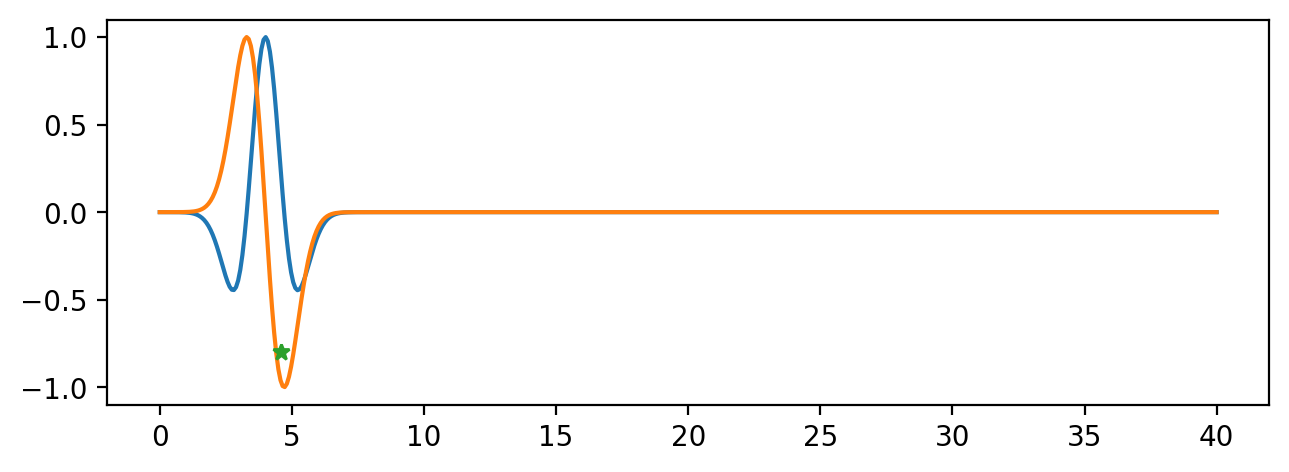

In [6]:
t = np.linspace(0,40,500)
t0_gtt = 4
tau_gtt = 1
Egt = (-2*(t)+2*t0_gtt)/tau_gtt**2*np.exp(-(t-t0_gtt)**2/tau_gtt**2)
Egtt = -(4*(t-t0_gtt)**2-2*tau_gtt**2)/2/tau_gtt**2*np.exp(-(t-t0_gtt)**2/tau_gtt**2)
plt.figure()
plt.plot(t,Egtt)
plt.plot(t,Egt/max(Egt))
plt.plot(t0_gtt+(2-np.sqrt(2))*tau_gtt,-0.8,'*')
np.sum(Egtt)

## Main scipts
The calculation of spatially- and temporally-resolved Generalized time-dependent Ginzburg–Landau (gTDGL) simulation. Deteails please refer Logan's paper [DOI: 10.1016/j.cpc.2023.108799].

### Part 1: Defining the device
Input the parameters for defining the SC thin film and constructing mesh for SC film.
<!-- Here we define a film with effective magnetic screening length $\Lambda=\lambda^2/d=(2\,\mu\mathrm{m})^2 / (0.05\,\mu\mathrm{m})=80\,\mu\mathrm{m}$, which is much larger than the dimensions of the sample. We therefore expect screening to be not important for this model. -->

In [7]:

### Unit setting

import scipy.constants as cons
from pint import UnitRegistry
ureg = UnitRegistry()

length_units = "um" # SI: m
time_units = 'ps' # SI: s
current_units = "mA" # SI: A
mass_units = 'kg' # SI: kg
angular_freq_units = 'THz' # SI: 1/s # for demonstration
field_units = "mT" # SI: kg/s^2/A
E_field_units = "kvolt/meter" # newton per coulomb (N/C), or volt per meter (V/m), SI: kg*m^2/s^3/A


### SC properties

xi = 100/1000 # Coherent length
london_lambda = 100/1000 # London penetration depth

rate_eph = 4 # [meV], 40 meV calculated from tau_eph = 100fs for YBCO, https://journals.aps.org/prb/abstract/10.1103/PhysRevB.59.1497
gap_0 = 20 # [meV], 20 meV https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.65.801, https://arxiv.org/pdf/cond-mat/9910367.pdf
# gap ~ 1/0.57*Tc https://people.phys.ethz.ch/~ivanov/cmt/1314/ssth-lectureBC.pdf
# For the case of Niobium gap_0=2.3meV & rate_eph=11, gamma is ~0.4 => no vortex
# gamma = 2/rate_eph*gap_0
gamma = 10
u = 5.79

temperature = 0.5 # Unit of Tc
disorder_epsilon = 1/temperature-1

# Size of sample
height = 2
width = 2
thickness = 2/1000

# Conductivity of sample
resistivity = 150e-6 * ureg('ohm * cm')
condictivity = (1/resistivity).to('1 / ohm / '+length_units)

layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=thickness, gamma=gamma, u=u, conductivity=condictivity.magnitude)
film = tdgl.Polygon("film", points=tdgl.geometry.box(width, height, points=301))
device = tdgl.Device(
    "bar",
    layer=layer,
    film=film,
    length_units=length_units,
)

In [8]:
# device.make_mesh(max_edge_length=xi / 4, smooth=100)
# fig, ax = device.plot(mesh=True, legend=False)
# device.mesh_stats()

### Check Unit
This scipts is based on unitless gTDGL funtion. So this cell is for cheking unit based on the parameters.


In [9]:
PrintSet = True
# PrintSet = False

## SC parameters

if PrintSet: print('Length scale of sample')
mu_0 = cons.mu_0 * ureg('newton/A**2')
xi_coherent = xi * ureg(length_units)
if PrintSet: print('- Coherent length: {!s}'.format(xi_coherent))
lambdaL = london_lambda * ureg(length_units)
if PrintSet: print('- London penetration depth: {!s}'.format(lambdaL))
d_thickness = thickness * ureg(length_units)
lambdaL_eff = lambdaL**2/d_thickness
if PrintSet: print('- Effective London penetration depth (l^2/d): {!s}'.format(lambdaL_eff))
if PrintSet: print('- Thickness: {!s}'.format(d_thickness))
L_height = height * ureg(length_units)
L_width = width * ureg(length_units)
if PrintSet: print('- Height: {!s}'.format(L_height))
if PrintSet: print('- Width: {!s}'.format(L_width))
screen_length = lambdaL**2/d_thickness
if PrintSet: print('- Screen length: {!s}'.format(screen_length))

if PrintSet: print('Condictivitye of sample')
resistivity = 150e-6 * ureg('ohm * cm')
condictivity = 1/resistivity
if PrintSet: print('- Given resistivity: {!s}'.format(resistivity))
if PrintSet: print('- Given condictivity: {!s}'.format(condictivity))

if PrintSet: print('Gap of sample')
E_eph = rate_eph * ureg('meV')
E_gap_0 = gap_0 * ureg('meV')
F_gap_0 = gap_0*0.242 * ureg('THz')
if PrintSet: print('- Given inelastic coupling rate: {!s}'.format(E_eph))
if PrintSet: print('- Given SC gap energy: {!s}'.format(E_gap_0))
if PrintSet: print('- Given SC gap energy: {!s}'.format(F_gap_0))
if PrintSet: print('- Strength of inelastic scattering: {!s}'.format(gamma))


## Unit of Time

if PrintSet: print('Time scale of sample')
# tau_0 = 2 * ureg('s')# mu_0 * condictivity * lambdaL**2
tau_0 = mu_0 * condictivity * lambdaL**2
tau_0 = tau_0.to('s')
if PrintSet: print('- SC dissipation time (tau_0): {!s}'.format(tau_0.to(time_units)))
speed_of_light = cons.speed_of_light * ureg('m/s')
revised_speed_of_light = (speed_of_light*tau_0.to(time_units).magnitude)
if PrintSet: print('- Speed of light (unit of tau_0):  {!s}'.format(revised_speed_of_light.to('um/ps')))


## Angular frequency of 1 THz (ω =2πf)

if PrintSet: print('Given frequency of light')
w_Freq = (1/tau_0)
f_input = 1 * w_Freq
w_input = 2*np.pi * f_input
if PrintSet: print('- SC dissipation rate: {!s}'.format(w_Freq.to(angular_freq_units)))
if PrintSet: print('- Expected frequency of light: {!s}'.format(f_input.to(angular_freq_units)))
if PrintSet: print('- Expected angular frequency of light: {!s}'.format(w_input.to(angular_freq_units)))
w0 = ((speed_of_light/(f_input.to(angular_freq_units))).to('um'))
if PrintSet: print('- Wavelength estimation for w0: '+str(w0))
if PrintSet: print('- Useful ratio estimation w0/xi: '+str(w0/xi_coherent))
if PrintSet: print('- Useful ratio estimation xi/tau_GL: '+str(xi_coherent.to('um')/tau_0.to('ps')))
if PrintSet: print('- Useful ratio estimation w0/tau_LG: '+str(w0.to('um')/tau_0.to('ps')))


## Electrical field and Magnetic field Phi_0

if PrintSet: print('E and B of light')
c_rev = revised_speed_of_light.to(length_units+'/'+time_units).magnitude
B0_check = (1/(c_rev)) * ureg(field_units)#*tau_0.to(time_units).magnitude
A0_check = (1/2/np.pi) * ureg(f"{field_units} * {length_units}") # Suppose w_input = 2*pi
B0 = B0_check
E0 = B0 * speed_of_light
if PrintSet: print('- |E0| of light: {!s}'.format(E0.to(E_field_units)))
if PrintSet: print('- |B0| of light: {!s}'.format(B0.to(field_units)))
if PrintSet: print('- |B0| of inside the function: {!s}'.format(B0_check.to(field_units)))
if PrintSet: print('- |A0| of inside the function: {!s}'.format(A0_check.to(field_units+'*'+length_units)))
if PrintSet: print('- 2pi|A0|/|B0|=Wavelength defined inside the function: {!s}'.format((A0_check*2*np.pi/B0_check).to(length_units)))
    # superconducting flux quantum: Phi0 = h/2e
    # upper critical field: Bc2 = μ0Hc2 = Phi0/2πξ^2
if PrintSet: print('Critical E and B of SC')
Phi0 = cons.h/2/cons.e * ureg('J/A')
Hc1 = Phi0/4/np.pi/mu_0/lambdaL**2*np.log(lambdaL/xi_coherent) # [ref] Gennes.P.D., pp.66, Eq (3-56), but no mu_0
Hc2 = Phi0/2/np.pi/mu_0/xi_coherent**2 # [ref] Logan
Hc  = Hc1/(np.pi/np.sqrt(24)*xi_coherent/lambdaL*np.log(lambdaL/xi_coherent)) # [ref] Gennes.P.D., pp.66, Eq (3-56), but no mu_0
Bc1 = mu_0*Hc1
Bc2 = mu_0*Hc2
Bc  = mu_0*Hc
A0_critical = xi_coherent*Bc2
# Econd = (1/2)VN(0)Δ2
# Econd = # [ref] Gennes.P.D., pp.66, Eq (3-41)
# Econd = Hc1**2/8/np.pi # [ref] Gennes.P.D., pp.66, Eq (3-1) # Gauss unit
Econd = Bc**2/2/mu_0
hbar = cons.hbar * ureg('J*s')
vF = np.pi*xi_coherent*E_gap_0/hbar # [ref] Gennes.P.D., pp.66, Eq (3-40)
if PrintSet: print('- Phi0: {!s}'.format(Phi0))
if PrintSet: print('- Hc1 of SC: {!s}'.format(Hc1))
if PrintSet: print('- Hc2 of SC: {!s}'.format(Hc2))
if PrintSet: print('- Bc1 of SC: {!s}'.format(Bc1.to('T')))
if PrintSet: print('- Bc2 of SC: {!s}'.format(Bc2.to('T')))
if PrintSet: print('- Critical vector potential A0: {!s}'.format(A0_critical.to('T*um')))
J0 = 4*xi_coherent*Bc2/mu_0/lambdaL**2
if PrintSet: print('- Unit current density: {!s}'.format(J0.to('A/um^2')))
if PrintSet: print('- Condensation energy (Bc**2/2/mu0): {!s}'.format(Econd.to('eV/'+length_units+'**3')))

""" Done!"""


Length scale of sample
- Coherent length: 0.1 micrometer
- London penetration depth: 0.1 micrometer
- Effective London penetration depth (l^2/d): 5.000000000000001 micrometer
- Thickness: 0.002 micrometer
- Height: 2 micrometer
- Width: 2 micrometer
- Screen length: 5.000000000000001 micrometer
Condictivitye of sample
- Given resistivity: 0.00015 centimeter * ohm
- Given condictivity: 6666.666666666667 / centimeter / ohm
Gap of sample
- Given inelastic coupling rate: 4 millielectron_volt
- Given SC gap energy: 20 millielectron_volt
- Given SC gap energy: 4.84 terahertz
- Strength of inelastic scattering: 10
Time scale of sample
- SC dissipation time (tau_0): 0.008377580414133334 picosecond
- Speed of light (unit of tau_0):  2.51153542444569 micrometer / picosecond
Given frequency of light
- SC dissipation rate: 119.36620725394143 terahertz
- Expected frequency of light: 119.36620725394143 terahertz
- Expected angular frequency of light: 749.9999995917182 terahertz
- Wavelength estimati

/usr/local/lib/python3.10/dist-packages/pint/facets/plain/quantity.py:998: RuntimeWarning: invalid value encountered in scalar divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


' Done!'

### Setting of Laguerre-Gaussian Beam
Inputing the parameters for Laguerre-Gaussian Beam. <br>
!!! Impotent !!! this cell will clean up the files in filefolder @folder_name.

[Warning] !!! ---Beam size is smaller than wavelength.--- !!!
File name /content/drive/MyDrive/Colab Notebooks/TempData/20240625_makeAnimation/20240510_Sim4-2_demo_LG00_linear_x_rec.txt
Time now (at Stockholm):2024-07-06 20:38:18.172817+02:00
:: Parameter record ::
[1] Length scale of sample
Coherent length (xi): 0.1 micrometer
London penetration depth (london_lambda): 0.1 micrometer
Thickness (thickness): 0.002 micrometer
Screen length (lambdaL**2/thickness): 5.000000000000001 micrometer
Ratio of length kapa (lambdaL/xi): 1.0 dimensionless
[2] Condictivity and  of sample
Resistivity (resistivity): 0.00015 centimeter * ohm
Condictivity (1/resistivity): 6666.666666666667 / centimeter / ohm
[3] Time scale of sample
Characteristic timescale (tau_0): 0.008377580414133334 picosecond
Characteristic rate (1/tau_0): 119.36620725394143 terahertz
Speed of light (unit of tau_0): 2511535.42444569 meter / second
c input into A_LG (c): 2.5115354244456904
tau input into A_LG (tau_0.to(s)): 0.00837758

<ipython-input-5-9cf802076a07>:614: UserWarning: linewidths is ignored by contourf
  contour_Bz = ax2.contourf(Xv, Yv, B_z, levels=50, linewidths=0.0, cmap="PRGn",vmin=Bzmin,vmax=Bzmax)


' Done ! '

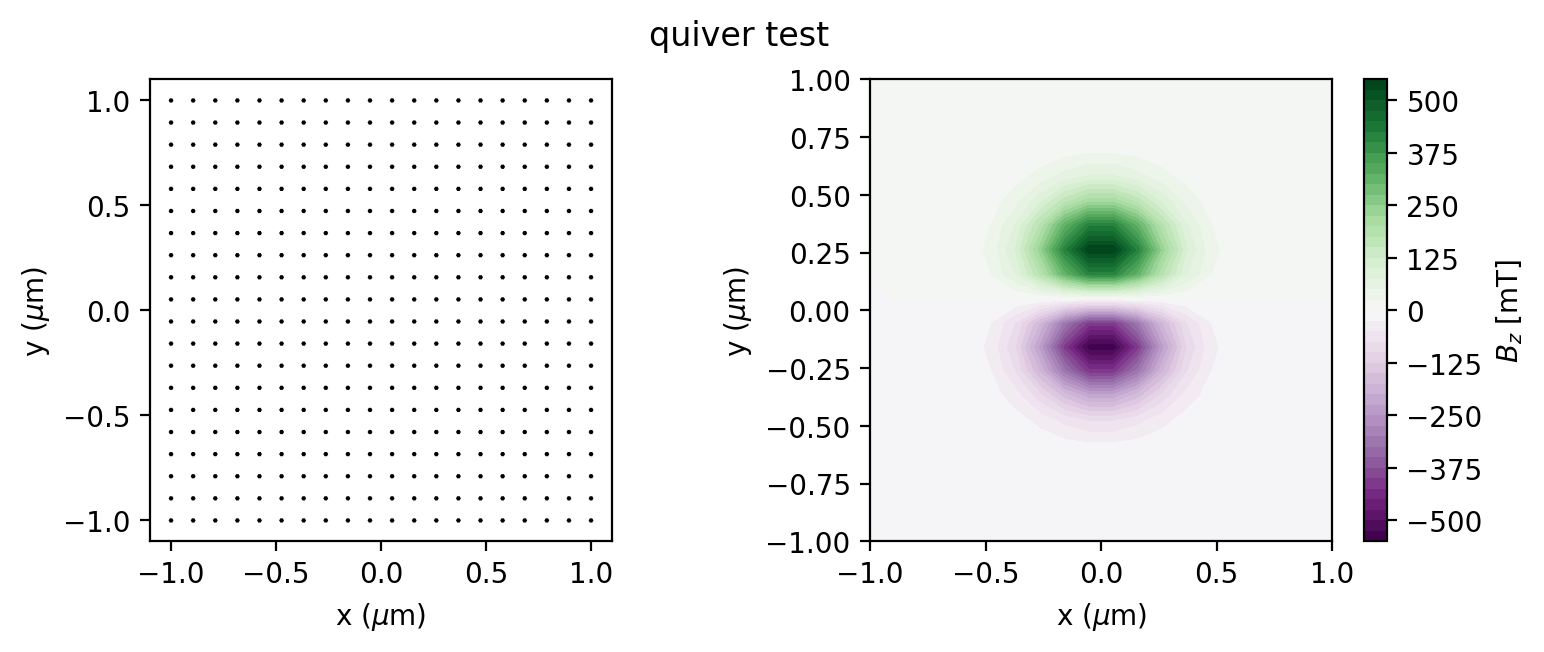

In [10]:
### Make filefolder for saving ###

## case1: w0 ~ 1/2
case_name = 'demo'
w_input = 2*np.pi * 0.5
w_input = 2*np.pi/40

solve_time = 40

w0 = 0.4 # 4*ro = 1um, ro=0.25um, sqrt(2)ro = 0.3535
E0i_set = [30]
xc_Gauss = 0
yc_Gauss = 0
quiver_scale = 4

screenSet = False
# screenSet = True
subtitle = '20240510_Sim4-2_'+case_name+'_'
newpath = r'/content/drive/MyDrive/Colab Notebooks/TempData/20240625_makeAnimation'
quiver_mesh_n = 20

if not os.path.exists(newpath): os.makedirs(newpath)
folder_name = newpath


### Parameter setting ###

light_source_type = 'lg00_l_x'

# solve_time = 20
# quiver_scale = 1
width_quiver = 0.1
dpi = 100
E0i = E0i_set[0]

## Select the parameters for the states of light sourceu
## options: 'lg00_l_x','lg00_l_y','lg00_c_l','lg00_c_r','lg01_l_x','lg01_l_y','lg01_c_c','lg01_c_r','lg01_c_a'
p, l, s, phi0_t, phi0_xy, polarization_modulation, output_file_head = light_state_contral(light_source_type)

constant_Bz = 0
t_on, t_off, time_evolute = [0.0, solve_time, True]

### Save and print

def E_input_frame(Xv,Yv,ti,*,take_real: bool=True):
    Zv = np.zeros_like(Xv)
    Ex, Ey, Ez =  (E_LG_t(Xv, Yv, Zv, t=ti, w=w_input, w0=w0, E0=E0i, xc_Gauss=xc_Gauss, yc_Gauss=yc_Gauss,
                             phi0_t=phi0_t, phi0_xy=phi0_xy, p=p, l=l, s=s,
                             tau=tau_0.to(time_units).magnitude, polarization_modulation=polarization_modulation,
                             t_on=t_on, t_off=t_off, Bz=constant_Bz, time_evolute=time_evolute,
                             angular_freq_units=angular_freq_units, length_units=length_units, E_field_units=E_field_units, time_units=time_units,))
    if take_real: return np.real(Ex)/E0i, np.real(Ey)/E0i
    else:         return Ex/E0i, Ey/E0i

# delete_files_in_directory(folder_name)
fig_title0 = folder_name+'/'+subtitle+output_file_head
X, Y, Xv, Yv, Zv = v_grid_generation(-width/2,width/2,-height/2,height/2,quiver_mesh_n)
Bz_max = find_max_Bz(Xv,Yv,1,0,revised_speed_of_light.to('um/ps').magnitude,w_input)
tau, c = Unit_check_save(E0i_set,w0,w_input,light_source_type,length_units,E_field_units,angular_freq_units,subtitle,solve_time,screenSet,folder_name,Bz_max)

quiver_test = True
if quiver_test:
        title_set = 'quiver test'
        E_x, E_y, E_z = (E_LG_t(Xv, Yv, Zv, t=4, w=w_input, w0=w0, E0=E0i_set[0], xc_Gauss=xc_Gauss, yc_Gauss=yc_Gauss,
                                 phi0_t=0*np.pi/2, phi0_xy=phi0_xy, p=p, l=l, s=s,
                                 t_on=t_on, t_off=t_off, Bz=constant_Bz, time_evolute=time_evolute,
                                 tau=tau_0.to(time_units).magnitude, polarization_modulation=polarization_modulation,
                                 angular_freq_units=angular_freq_units, length_units=length_units, E_field_units=E_field_units, time_units=time_units,))
        B_x, B_y, B_z = E2Bv(Xv,Yv,E_x,E_y,constant_Bz,c,w_input)
        plot_EM(X,Y,np.real(E_x),np.real(E_y),np.real(B_z),E0i=E0i_set[0],title=title_set,figsize=(9,3),scale=quiver_scale,dpi=dpi,width_quiver=width_quiver)
print(B_z.max())
""" Done ! """


In [11]:
import h5py

folder_name = r'/content/drive/MyDrive/Colab Notebooks/TempData/20240625_makeAnimation'
# folder_name = r'C:/Users/TTYeh/Documents/TTY/20240627_M1SI_makevideo/20240627_make_animation'
file_name = 'LG00_linear_x_time40_SC_solution2.h5'

SC_solution = h5py.File(folder_name+'/'+file_name,'r+')
SC_solution.path = folder_name+'/'+file_name

In [12]:
# SC_solution
import os
os.getcwd()
os.listdir()
# os.chdir('20240510_Sim4-2_demo')
# os.listdir()

['.config', 'drive', 'sample_data']

In [13]:
from tdgl.solution.data import TDGLData, get_edge_quantity_data, load_state_data
from tdgl.finite_volume.operators import build_gradient

def get_vorticity(
    h5file: h5py.File,
    mesh,
    quantity: Quantity,
    frame: int,
):
    """Get data to plot.

    Args:
        h5file: The data file.
        mesh: The mesh used in the simulation.
        quantity: The quantity to return.
        frame: The current frame.

    Returns:
        A tuple of the values for the color plot, the directions for the
        quiver plot and the limits for the color plot.
    """
    tdgl_data = TDGLData.from_hdf5(h5file, frame)
    psi = tdgl_data.psi
    mu = tdgl_data.mu
    epsilon = tdgl_data.epsilon
    a_applied = tdgl_data.applied_vector_potential
    a_induced = tdgl_data.induced_vector_potential
    supercurrent = tdgl_data.supercurrent
    normal_current = tdgl_data.normal_current
    nsites = len(mesh.sites)

    if True:
        j_sc_site = mesh.get_quantity_on_site(supercurrent)
        j_nm_site = mesh.get_quantity_on_site(normal_current)
        j_site = j_sc_site + j_nm_site
        gradient = build_gradient(mesh)
        normalized_directions = mesh.edge_mesh.normalized_directions
        grad_jx = gradient @ j_site[:, 0]
        grad_jy = gradient @ j_site[:, 1]
        djy_dx = grad_jy * normalized_directions[:, 0]
        djx_dy = grad_jx * normalized_directions[:, 1]
        vorticity_on_edges = djy_dx - djx_dy
        vorticity = mesh.get_quantity_on_site(vorticity_on_edges, vector=False)
        vmax = max(np.abs(np.max(vorticity)), np.abs(np.min(vorticity)))
    return vorticity#, np.zeros((nsites, 2)), [-vmax, vmax]


def get_J(
    h5file: h5py.File,
    mesh,
    quantity: Quantity,
    frame: int,
):
    """Get data to plot.

    Args:
        h5file: The data file.
        mesh: The mesh used in the simulation.
        quantity: The quantity to return.
        frame: The current frame.

    Returns:
        A tuple of the values for the color plot, the directions for the
        quiver plot and the limits for the color plot.
    """
    tdgl_data = TDGLData.from_hdf5(h5file, frame)
    psi = tdgl_data.psi
    mu = tdgl_data.mu
    epsilon = tdgl_data.epsilon
    a_applied = tdgl_data.applied_vector_potential
    a_induced = tdgl_data.induced_vector_potential
    supercurrent = tdgl_data.supercurrent
    normal_current = tdgl_data.normal_current
    nsites = len(mesh.sites)
    j_sc_site = mesh.get_quantity_on_site(supercurrent)
    j_nm_site = mesh.get_quantity_on_site(normal_current)

    if quantity=='n': j_site = j_nm_site
    elif quantity=='s': j_site = j_sc_site
    else: j_site = j_sc_site + j_nm_site
    J = np.sqrt(j_site[:, 0]**2 + j_site[:, 1]**2)

    return J #, np.zeros((nsites, 2)), [-vmax, vmax]

def get_J_xy(
    h5file: h5py.File,
    mesh,
    quantity: Quantity,
    frame: int,
    Jmax: float=0.2,
):
    """Get data to plot.

    Args:
        h5file: The data file.
        mesh: The mesh used in the simulation.
        quantity: The quantity to return.
        frame: The current frame.

    Returns:
        A tuple of the values for the color plot, the directions for the
        quiver plot and the limits for the color plot.
    """
    tdgl_data = TDGLData.from_hdf5(h5file, frame)
    psi = tdgl_data.psi
    mu = tdgl_data.mu
    epsilon = tdgl_data.epsilon
    a_applied = tdgl_data.applied_vector_potential
    a_induced = tdgl_data.induced_vector_potential
    supercurrent = tdgl_data.supercurrent
    normal_current = tdgl_data.normal_current
    nsites = len(mesh.sites)
    j_sc_site = mesh.get_quantity_on_site(supercurrent)
    j_nm_site = mesh.get_quantity_on_site(normal_current)

    if quantity=='n': j_site = j_nm_site
    elif quantity=='s': j_site = j_sc_site
    else: j_site = j_sc_site + j_nm_site
    J = np.sqrt(j_site[:, 0]**2 + j_site[:, 1]**2)
    Jxnorm = j_site[:, 0]/Jmax
    Jynorm = j_site[:, 1]/Jmax

    return J, Jxnorm, Jynorm #, np.zeros((nsites, 2)), [-vmax, vmax]


# from tdgl.finite_volume import mesh
from tdgl.finite_volume.mesh import Mesh
from tdgl.finite_volume.edge_mesh import EdgeMesh

def from_hdf5(h5group: h5py.Group) -> "Mesh":
        """Load a mesh from an HDF5 file.

        Args:
            h5group: The HDF5 group to load the mesh from.

        Returns:
            The loaded mesh.
        """
        if not ("sites" in h5group and "elements" in h5group):
            raise IOError("Could not load mesh due to missing data.")

        if Mesh.is_restorable(h5group):
            polygons_flat = np.array(h5group["voronoi_polygons_flat"])
            voronoi_indices = np.array(h5group["voronoi_split_indices"])
            voronoi_polygons = np.split(polygons_flat, voronoi_indices)
            return Mesh(
                sites=np.array(h5group["sites"]),
                elements=np.array(h5group["elements"], dtype=np.int64),
                boundary_indices=np.array(h5group["boundary_indices"], dtype=np.int64),
                areas=np.array(h5group["areas"]),
                dual_sites=np.array(h5group["dual_sites"]),
                voronoi_polygons=voronoi_polygons,
                edge_mesh=EdgeMesh.from_hdf5(h5group["edge_mesh"]),
            )
        # Recreate mesh from triangulation data if not all data is available
        return Mesh.from_triangulation(
            sites=np.array(h5group["sites"]).squeeze(),
            elements=np.array(h5group["elements"]),
        )

def find_index(POS,val):
    min_rec = np.zeros(len(val))
    for i in range(len(val)):
        min_rec[i] = np.sum(abs(val[i,:]-POS)**2)
    return np.argmin(min_rec)

''' Done. '''

' Done. '

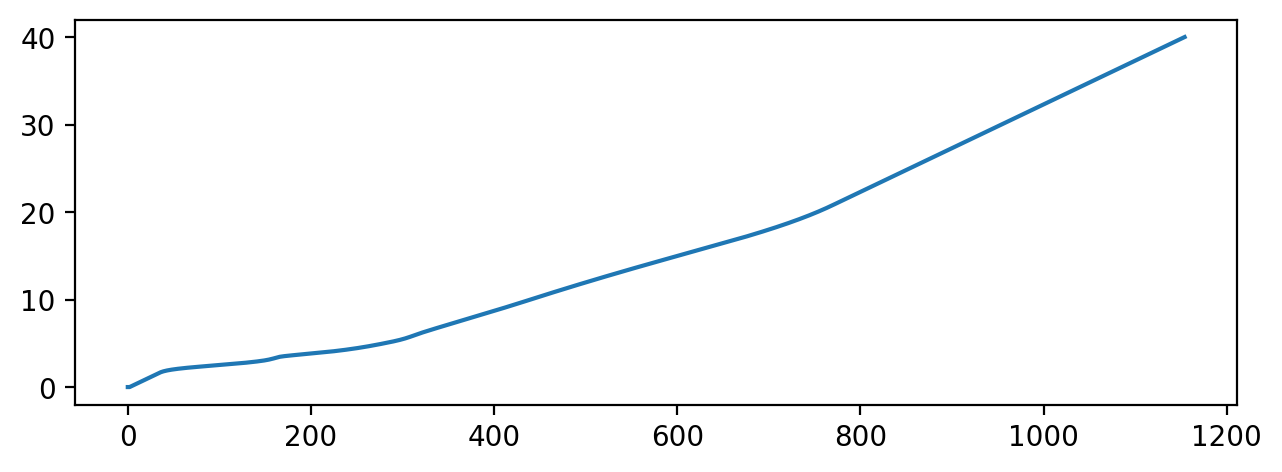

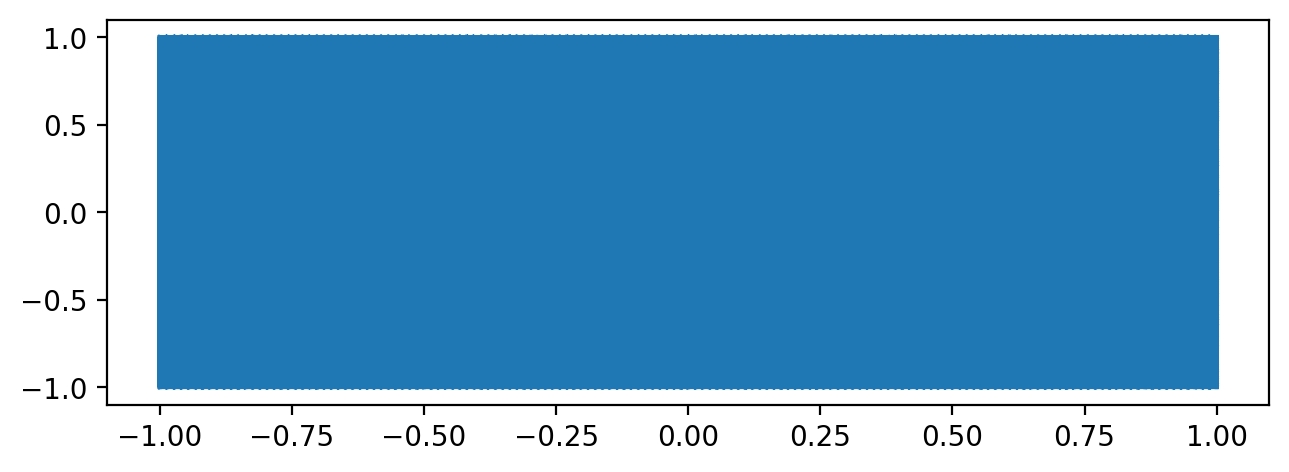

In [14]:

# Load h5 data
# import h5py

# folder_name = os.getcwd()
# # file_name = 'LG00_linear_x_time120_SC_solution_M1fig3b.h5' # !!!!!!!!!!!!!!!!!!!!!!!!!!!11 Avinash (change name)
# solve_time = 120 # !!!!!!!!!!!!!!!!!!!!!!!!!!!11 Avinash (This parameter need ti be manually inputed, I will tell you)

SC_solution = h5py.File(folder_name+'/'+file_name,'r+')
SC_solution.path = folder_name+file_name

# Time
frameN = np.array([])
time = np.array([0])

for i in SC_solution['data']:
    frameN = np.append(frameN,int(i))
    if int(i)>0: time = np.append(time,time[int(i)-1]+SC_solution['data'][i]['running_state']['dt'][0])
time = time/max(time)*solve_time

# Mesh
voronoi_POS = SC_solution['solution']['device']['mesh']['sites']
voronoi_tri = SC_solution['solution']['device']['mesh']['elements']
Xtri = SC_solution['solution']['device']['mesh']['sites'][:,0]
Xtri = Xtri/max(Xtri)*width/2
Ytri = SC_solution['solution']['device']['mesh']['sites'][:,1]
Ytri = Ytri/max(Ytri)*height/2
Xtri_center = SC_solution['solution']['device']['mesh']['edge_mesh']['centers'][:,0]
Xtri_center = Xtri_center/max(Xtri_center)*width/2
Ytri_center = SC_solution['solution']['device']['mesh']['edge_mesh']['centers'][:,1]
Ytri_center = Ytri_center/max(Ytri_center)*height/2

# print(frameN)
plt.figure()
plt.plot(frameN, time)
# plt.plot(time)

plt.figure()
plt.triplot(Xtri, Ytri, voronoi_tri,)


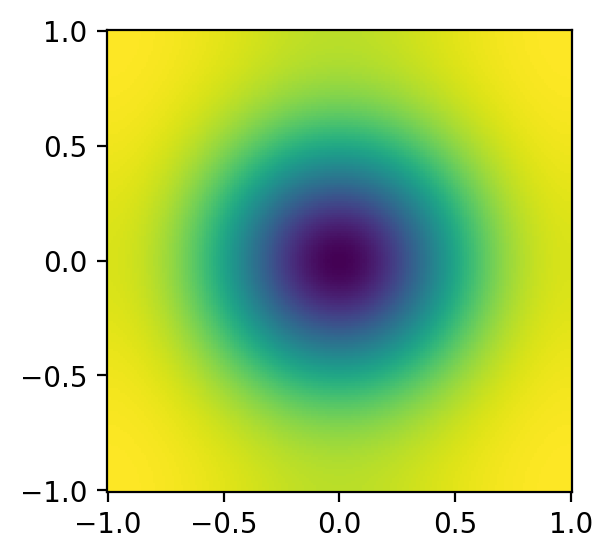

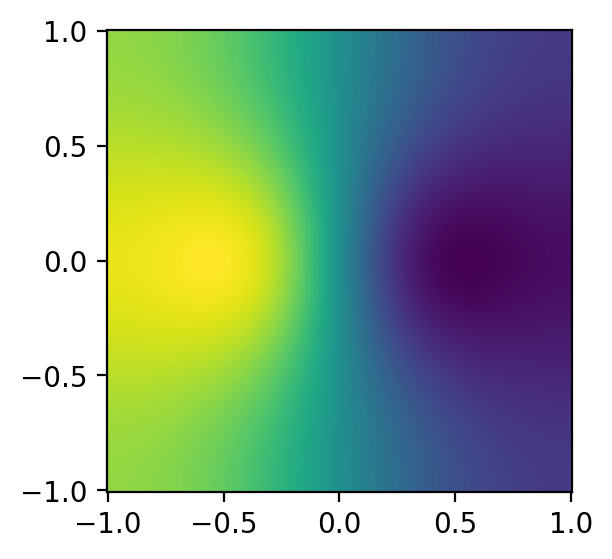

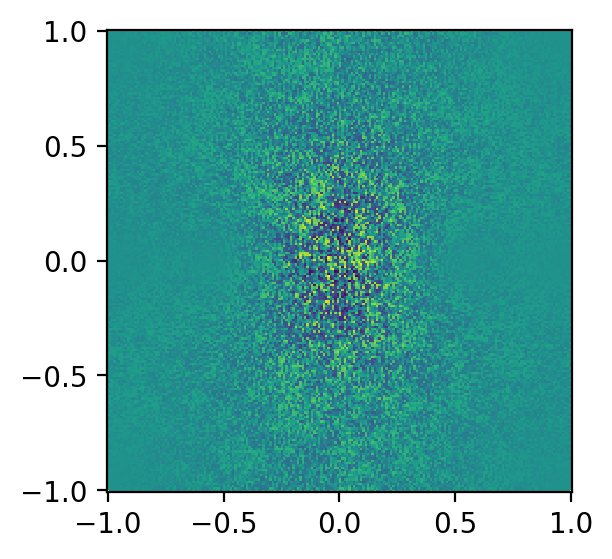

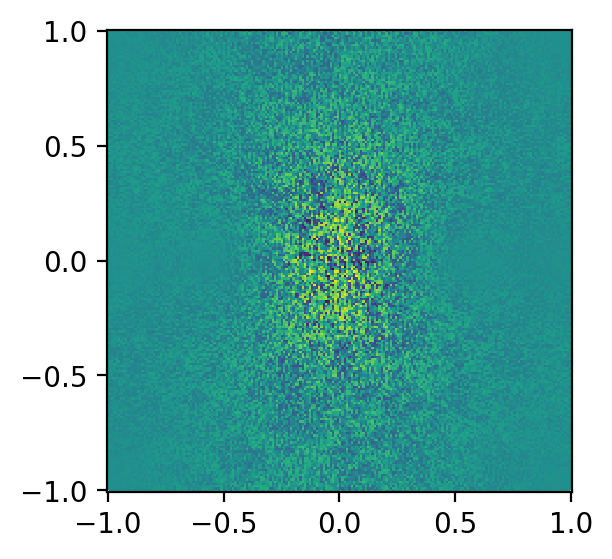

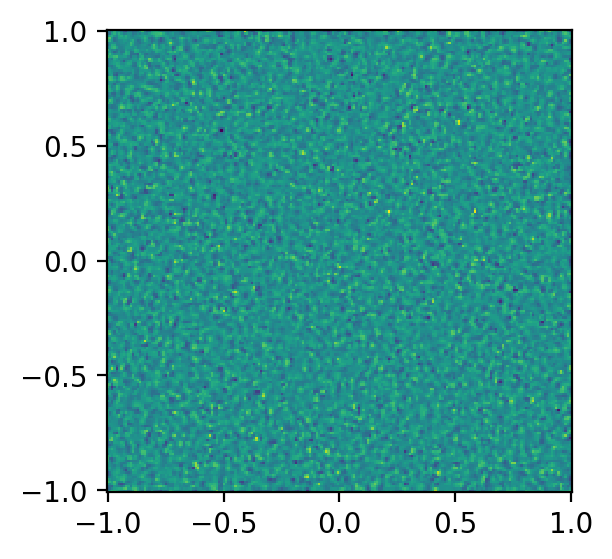

In [15]:
from scipy import interpolate
# from tdgl.finite_volume import mesh

mesh_n = 200
Xmax, Ymax = [width,height]
X = np.linspace(-Xmax/2,Xmax/2,mesh_n)
Y = np.linspace(-Ymax/2,Ymax/2,mesh_n)
Xv, Yv = np.meshgrid(X, Y)
Zv = np.zeros_like(Xv)
# mesh_input = SC_solution['solution']['device']['mesh']
# mesh_input.sites = SC_solution['solution']['device']['mesh']['sites']
mesh_input = from_hdf5(SC_solution['solution']['device']['mesh'])

ti = 90 # !!!!!!!!!!!!!!!!!!!!!!!!!!!11 Avinash (change the profile at different time frame)
frame_ti = findval(time,ti)
psi_ti = interpolate.griddata(np.array([Xtri,Ytri]).T,
        abs(SC_solution['data'][str(frame_ti)]['psi'][:]),(Xv, Yv), method='linear',)
phase_ti = interpolate.griddata(np.array([Xtri,Ytri]).T,
        np.angle(SC_solution['data'][str(frame_ti)]['psi'][:]),(Xv, Yv), method='linear',)
supercurrent_ti = interpolate.griddata(np.array([Xtri_center,Ytri_center]).T,
        SC_solution['data'][str(frame_ti)]['supercurrent'][:],(Xv, Yv), method='linear',)
normal_current_ti = interpolate.griddata(np.array([Xtri_center,Ytri_center]).T,
        SC_solution['data'][str(frame_ti)]['normal_current'][:],(Xv, Yv), method='linear',)
vorticity_ti = interpolate.griddata(np.array([Xtri,Ytri]).T,
        get_vorticity(SC_solution,mesh_input,"vorticity",str(frame_ti)),(Xv, Yv), method='linear',)

figsize=(3,3)
plt.figure(figsize=figsize)
plt.pcolor(Xv,Yv,psi_ti)
plt.figure(figsize=figsize)
plt.pcolor(Xv,Yv,phase_ti)
plt.figure(figsize=figsize)
plt.pcolor(Xv,Yv,supercurrent_ti)
plt.figure(figsize=figsize)
plt.pcolor(Xv,Yv,normal_current_ti)
plt.figure(figsize=figsize)
plt.pcolor(Xv,Yv,vorticity_ti)


100%|██████████| 301/301 [08:17<00:00,  1.65s/it]


3.8381951248182418
0.7215287650845985


' Done! '

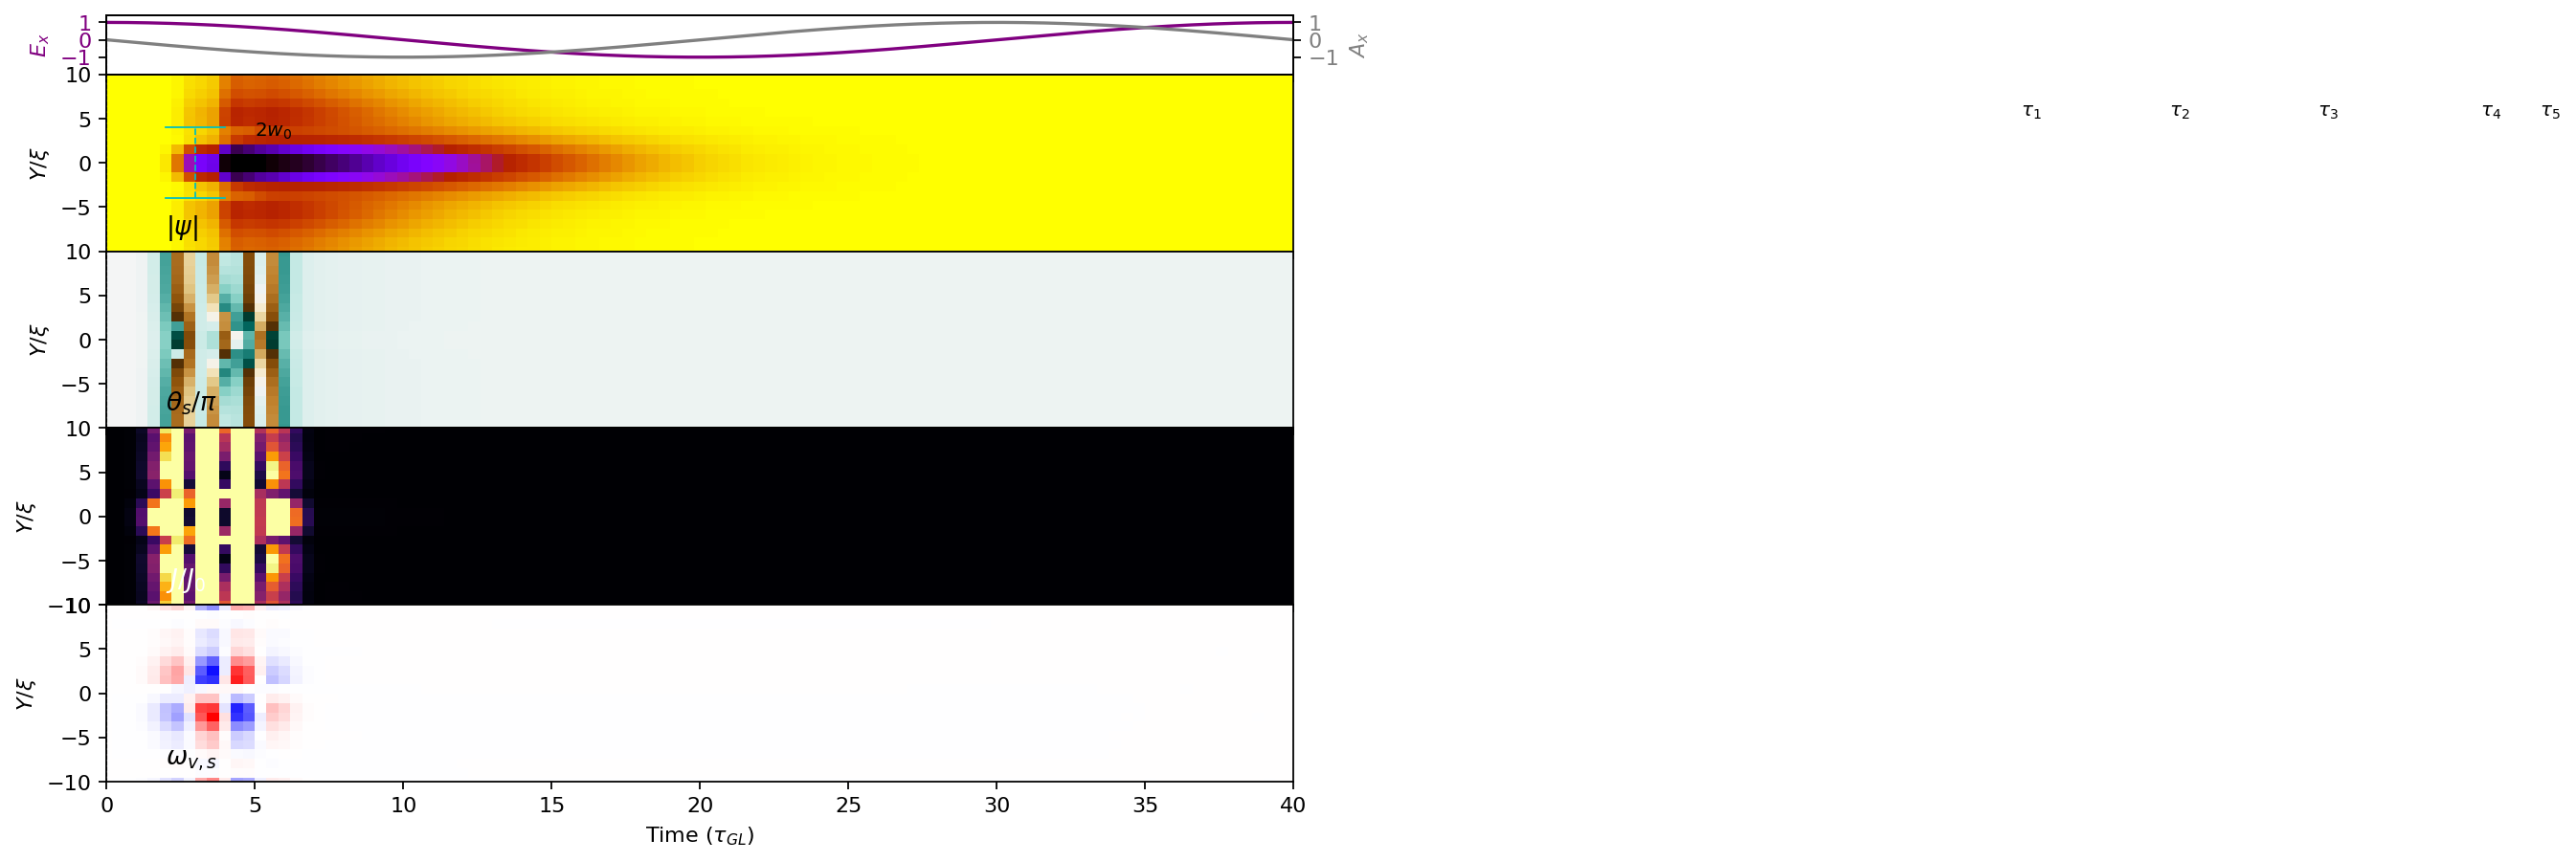

In [16]:
from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from scipy import interpolate
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# new_cbar = cm.get_cmap("bwr", 100)
K0 = 2.095153729869544

def scan_value(num):
    ti_show = np.linspace(0, 120, num=num)
    # ti_show = np.linspace(0, 120, num=41) # test

    X = np.linspace(-width/2,width/2,quiver_mesh_n)
    Y = np.linspace(-height/2,height/2,quiver_mesh_n)
    Xv, Yv = np.meshgrid(X, Y)
    dx, dy = [X[2]-X[1], Y[2]-Y[1]]

    px = findval(X,0)
    py = findval(Y,0)
    # ptri = find_index(POStrack[POSi,:],np.array([Xtri,Ytri]).T)
    psi_plot = np.zeros([len(Y),len(ti_show)])
    phase_plot = np.zeros([len(Y),len(ti_show)])
    vor_plot = np.zeros([len(Y),len(ti_show)])
    J_plot = np.zeros([len(Y),len(ti_show)])
    PhiB_plot = np.zeros(len(ti_show))


    for ti in tqdm(ti_show):
        frame_ti = findval(time,ti)
        psi_interp = interpolate.griddata(np.array([Xtri,Ytri]).T,
                    np.abs(SC_solution['data'][str(frame_ti)]['psi']),(Xv, Yv), method='cubic',)
        phase_interp = interpolate.griddata(np.array([Xtri,Ytri]).T,
                    np.angle(SC_solution['data'][str(frame_ti)]['psi']),(Xv, Yv), method='cubic',)
        vorticity_ti = interpolate.griddata(np.array([Xtri,Ytri]).T,
                    get_vorticity(SC_solution,mesh_input,"vorticity",str(frame_ti)),(Xv, Yv), method='linear',)
        J_ti = interpolate.griddata(np.array([Xtri,Ytri]).T,
                    get_J(SC_solution,mesh_input,"Js+Jn",str(frame_ti)),(Xv, Yv), method='linear',)
        psi_plot[:,findval(ti_show,ti)] = np.array(psi_interp[:,px])
        phase_plot[:,findval(ti_show,ti)] = np.array(phase_interp[:,px])
        vor_plot[:,findval(ti_show,ti)] = np.array(vorticity_ti[:,px])
        J_plot[:,findval(ti_show,ti)] = np.array(J_ti[:,px])
        E_x, E_y = E_input_frame(Xv,Yv,ti,take_real=False)
        B_x, B_y, B_z = E2Bv(Xv,Yv,E0i*E_x,E0i*E_y,constant_Bz,c,w_input)
        PhiB_plot[findval(ti_show,ti)] = np.sum(np.sum(abs(B_z)/2*dx*dy))

    mag_cmap = "gnuplot"#"viridis"
    phase_cmap = "BrBG"#"twilight_shifted"
    vorticity_cmap = "bwr"
    J_cmap = "inferno"
    # rset = np.linspace(0, 1, 100)
    # vorticity_cmap = ListedColormap((new_cbar(rset))**1.5)#"bwr"
    shading = "gouraud"
    psi_label = "$|\\psi|$"
    phase_label = "$\\theta_s / \\pi$"
    vorticity_label = "$\\omega_{v,s}$"
    J_label = "$J/J_0$"
    dpi = 80

    plt.rcParams.update({'font.serif': 'Times New Roman',
                                    'font.size': 10.0,
                                    'axes.labelsize': 'Medium',
                                    'axes.labelweight': 'normal',
                                    'axes.linewidth': 0.8,
                                     ###########################################
                                     # THIS IS THE IMPORTANT ONE FOR STRETCHING
                                     # default is [6,4] but...i changed it to
                                    'figure.figsize':[15,5]   # THIS ONE #
                                  })

    xi = xi_coherent.magnitude
    X_curve, Y_curve = np.meshgrid(ti_show, Y/xi)

    # -------------------------------------- Fig set

    ## Figures

    # Creates a 2 row, 1 column plot that shares the x-axis
    fig, ax = plt.subplots(5,1, figsize=(10,6.5), sharex=True, dpi=dpi,  height_ratios = [1, 3, 3, 3, 3])#, constrained_layout=True)
    style_set = ['-','--','-.',]
    # Set the spaceing between plots to zero
    plt.subplots_adjust(hspace=0)

    # Get color list from physrev.mplstyle for selecting colors for plot
    # for matplotlib <= 1.5.x
    color = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

    ## Plot 1

    ax1 = ax[0]
    color = 'purple'
    # ax1.set_xlabel('Time ($\\tau_{GL}$)')
    ax1.set_ylabel('$E_{x}$', color=color)
    ax1.plot(time, 1*np.cos(time*w_input), color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim([-1.99,1.4])

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'gray'
    ax2.set_ylabel('$A_{x}$', color=color)  # we already handled the x-label with ax1
    ax2.plot(time, -1*np.sin(time*w_input), color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([-1.99,1.4])

    for Nti in range(int(solve_time*w_input/2/np.pi)+1): ax1.axvline(x=(Nti)*(2*np.pi/w_input),color='k',linestyle='dashed',linewidth=0.5)

    ## Plot 2

    ax1 = ax[1]
    Z_curve = np.copy(psi_plot)
    ax1.pcolor(X_curve,Y_curve,Z_curve,cmap=mag_cmap,vmin=0,vmax=1)
    ax1.set_ylabel('$Y/\\xi$')
    # ax1.legend(frameon=False,loc="center",ncol=3)
    ax1.set_ylim([Y_curve.min(),Y_curve.max()])
    ax1.yaxis.set_major_locator(MaxNLocator(prune='upper'))
    majors = [-5, 0, 5, 10]
    ax1.yaxis.set_major_locator(ticker.FixedLocator(majors))
    ax1.text(2,-8,psi_label,fontsize=12)

    ax1.plot([3,3],[-0.4/xi,0.4/xi],'--',color="c",lw=0.8)
    ax1.plot([3-1,3+1],[0.4/xi,0.4/xi],'-',color="c",lw=0.8)
    ax1.plot([3-1,3+1],[-0.4/xi,-0.4/xi],'-',color="c",lw=0.8)
    ax1.text(5,3,'$2w_0$',fontsize=9,color='k')

    for Nti in range(int(solve_time*w_input/2/np.pi)+1): ax1.axvline(x=(Nti)*(2*np.pi/w_input),color='k',linestyle='dashed',linewidth=0.5)

    ti_set = np.array([65.0,70.0,75.0,80.5,82.5])
    for ti in ti_set:
        ax1.plot([ti,ti],[-0.4/xi,0.4/xi],'--',color="c",lw=0.8)
        ax1.text(ti-0.5,(+5.3)*(+1)**(findval(ti_set,ti)+1),'$\\tau_{'+str(findval(ti_set,ti)+1)+'}$',fontsize=9,color='k')

    ## Plot 3

    Z_curve = np.copy(phase_plot)/np.pi
    ax1 = ax[2]
    ax1.pcolor(X_curve,Y_curve,Z_curve,cmap=phase_cmap,vmin=-1,vmax=1)
    ax1.set_ylim([Y_curve.min(),Y_curve.max()])
    for Nti in range(int(solve_time*w_input/2/np.pi)+1): ax1.axvline(x=(Nti)*(2*np.pi/w_input),color='k',linestyle='dashed',linewidth=0.5)
    ax1.set_ylabel('$Y/\\xi$')
    majors = [-5, 0, 5, 10]
    ax1.yaxis.set_major_locator(ticker.FixedLocator(majors))
    ax1.text(2,-8,phase_label,color='k',fontsize=12)


    ## Plot 4

    Z_curve = np.copy(J_plot)/K0
    Z_curve[:,-1] = Z_curve[:,-1]*0
    ax1 = ax[3]
    ax1.pcolor(X_curve,Y_curve,Z_curve,cmap=J_cmap,vmin=0,vmax=0.150)
    ax1.set_ylim([Y_curve.min(),Y_curve.max()])
    for Nti in range(int(solve_time*w_input/2/np.pi)+1): ax1.axvline(x=(Nti)*(2*np.pi/w_input),color='k',linestyle='dashed',linewidth=0.5)
    ax1.set_ylabel('$Y/\\xi$')
    majors = [-10, -5, 0, 5, 10]
    ax1.yaxis.set_major_locator(ticker.FixedLocator(majors))
    ax1.text(2,-8,J_label,fontsize=12,color='white')

    ax1.set_xlim([0,time.max()])

    ## Plot 5

    Z_curve = np.copy(vor_plot)
    Z_curve[:,-1] = Z_curve[:,-1]*0
    ax1 = ax[4]
    ax1.pcolor(X_curve,Y_curve,Z_curve/Z_curve.max(),cmap=vorticity_cmap,vmin=-1,vmax=1)
    ax1.set_ylim([Y_curve.min(),Y_curve.max()])
    for Nti in range(int(solve_time*w_input/2/np.pi)+1): ax1.axvline(x=(Nti)*(2*np.pi/w_input),color='k',linestyle='dashed',linewidth=0.5)
    ax1.set_ylabel('$Y/\\xi$')
    majors = [-10, -5, 0, 5, 10]
    ax1.yaxis.set_major_locator(ticker.FixedLocator(majors))
    ax1.text(2,-8,vorticity_label,fontsize=12)

    ax1.set_xlabel('Time ($\\tau_{GL}$)')
    ax1.set_xlim([0,time.max()])

    return psi_plot, phase_plot, vor_plot, J_plot, PhiB_plot, fig

psi_plot, phase_plot, vor_plot, J_plot, PhiB_plot, fig = scan_value(301)
fig.show()

file_name_save = 'test_a.png'
plt.savefig(folder_name+'/'+file_name_save)

K0 = 2.095153729869544
print(J_plot.max())
print(vor_plot.max())
''' Done! '''

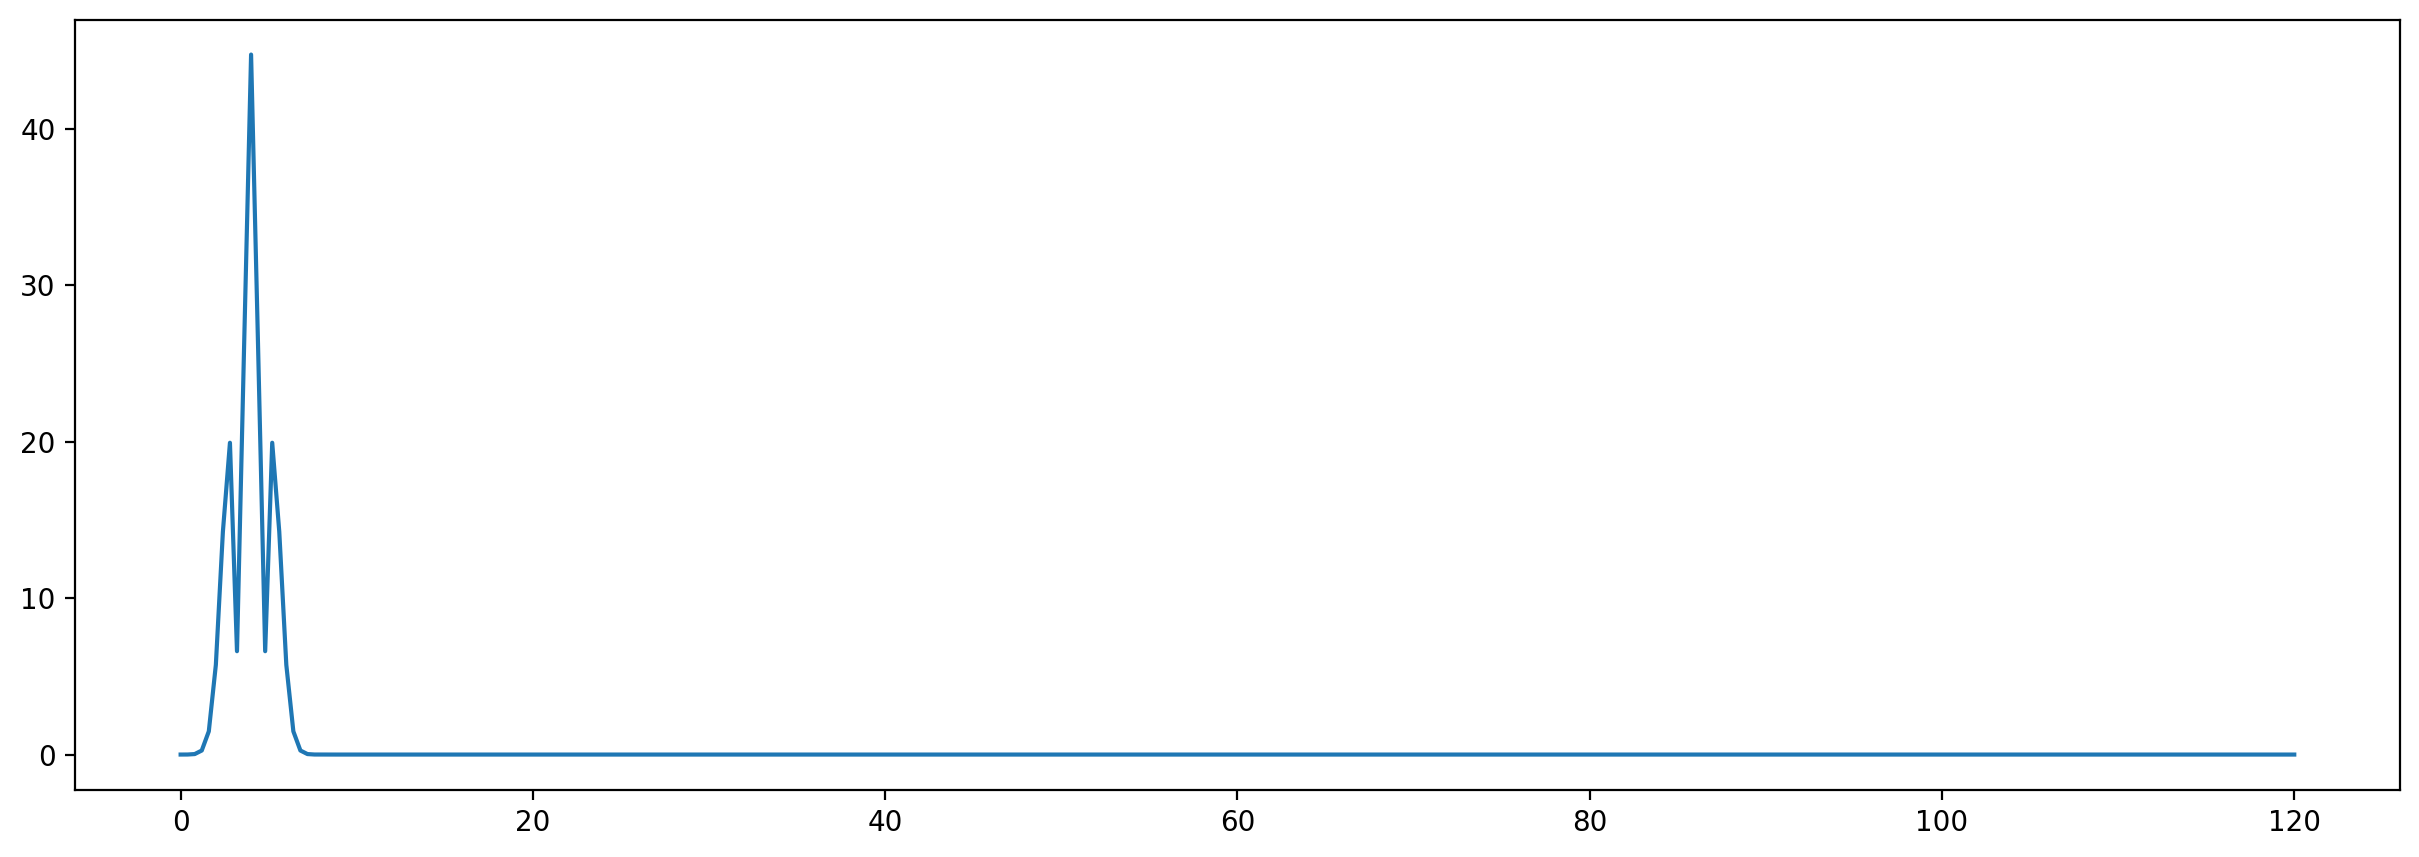

In [17]:
num=301
plt.figure()
plt.plot(np.linspace(0, 120, num=num), PhiB_plot[:num]/Phi0.to(field_units+'*'+length_units+'^2').magnitude)
file_name_save = 'PhiB_a.png'
plt.savefig(folder_name+'/'+file_name_save)

In [21]:
dpi=200
fps=20
# w_input = 2*np.pi/40
# E0i = 2
solve_time = 40
save_frame = 2
max_frame = int(len(time)/save_frame)
frame_set = np.arange(max_frame)*save_frame
frame_set = frame_set[345+123:]

iniframe = frame_set[0]
print(iniframe)

# left, bottom, width, height = (0, -2, time[3420], 4)
# rect = plt.Rectangle((left, bottom), width, height,
#                      facecolor="green", alpha=1)
# ax.add_patch(rect)
# E0i
# # Bc2_value
# find_max_Bz(Xv,Yv,2,0,c,w_input)
# J_plot.max()
# # c
# # folder_name
# len(time)

936


17.788492503407866

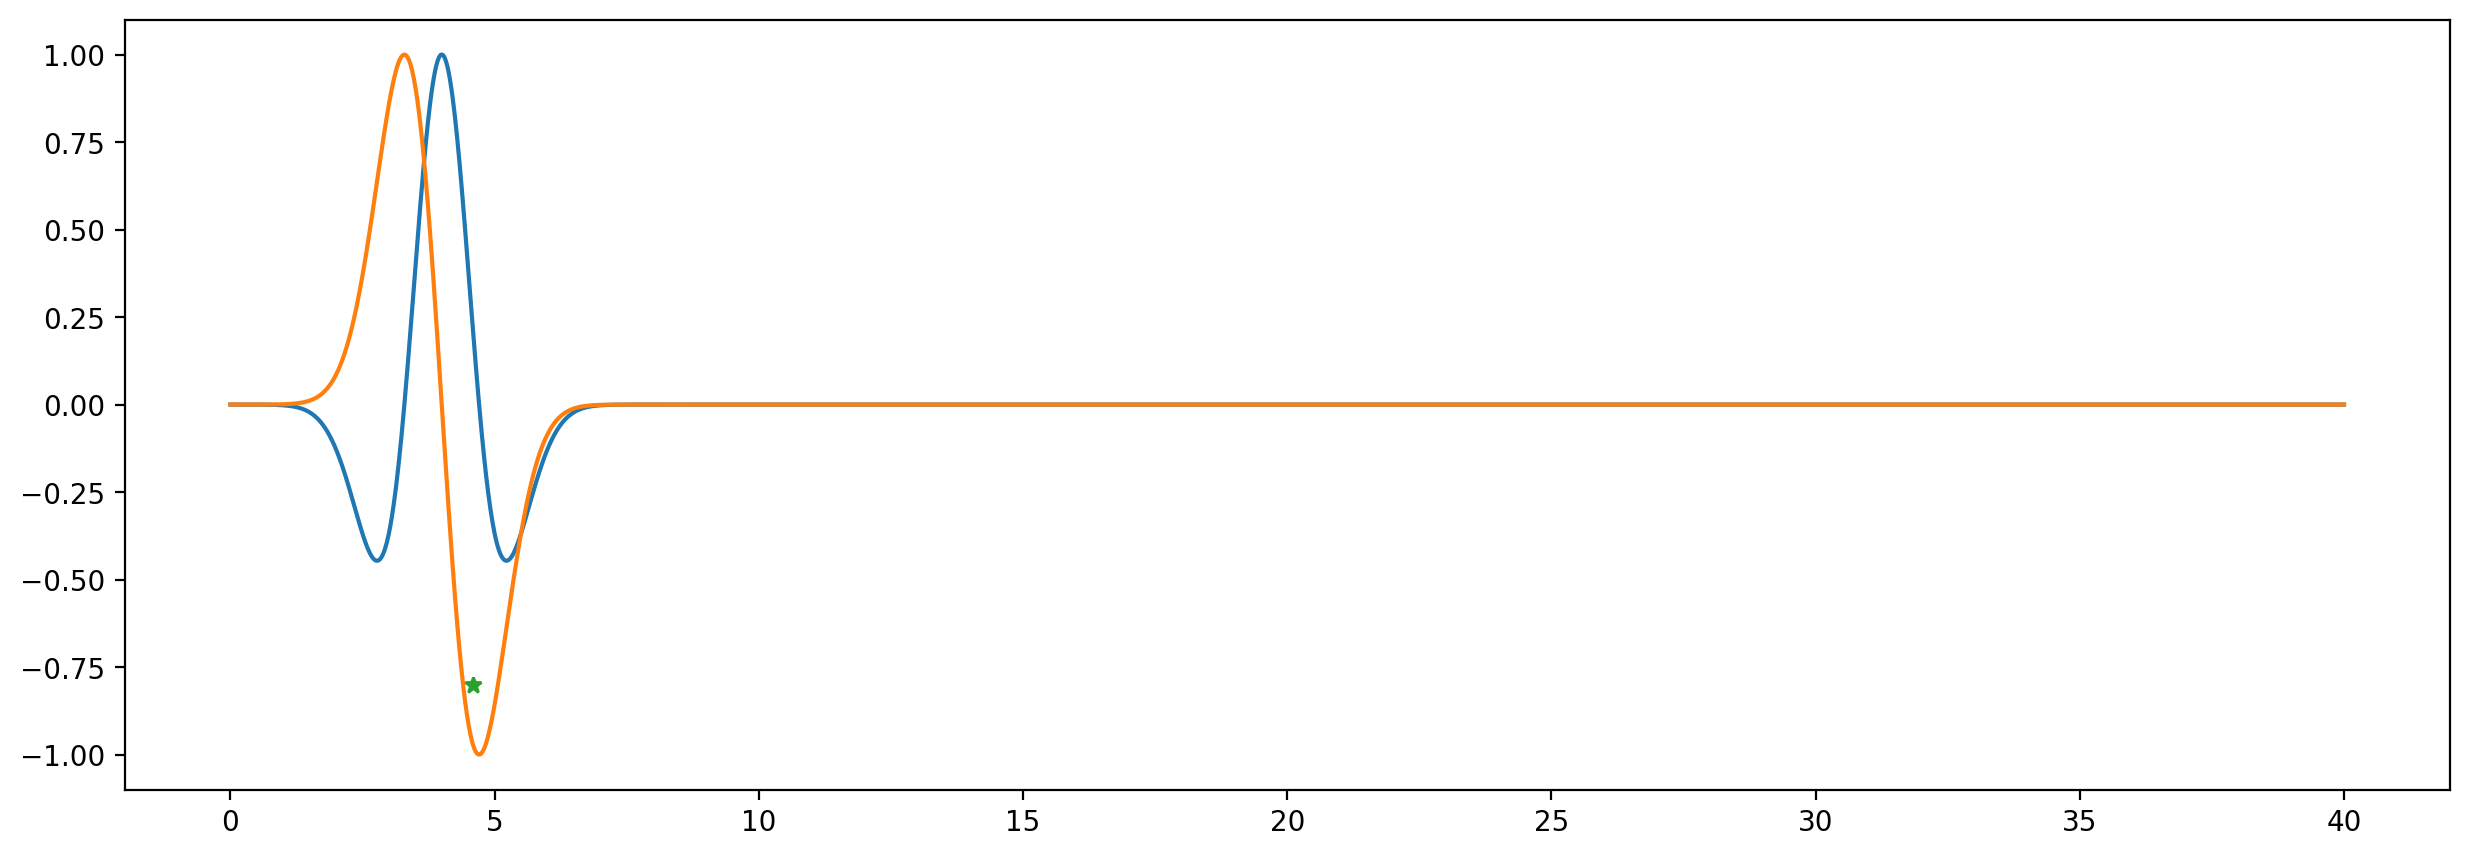

In [19]:
t = np.copy(time)
t0_gtt = 4
tau_gtt = 1
Egt = (-2*(t)+2*t0_gtt)/tau_gtt**2*np.exp(-(t-t0_gtt)**2/tau_gtt**2)
Egtt = -(4*(t-t0_gtt)**2-2*tau_gtt**2)/2/tau_gtt**2*np.exp(-(t-t0_gtt)**2/tau_gtt**2)
plt.figure()
plt.plot(t,Egtt)
plt.plot(t,Egt/max(Egt))
plt.plot(t0_gtt+(2-np.sqrt(2))*tau_gtt,-0.8,'*')
np.sum(Egtt)

936


100%|██████████| 109/109 [1:46:07<00:00, 58.42s/it] 


' Done. '

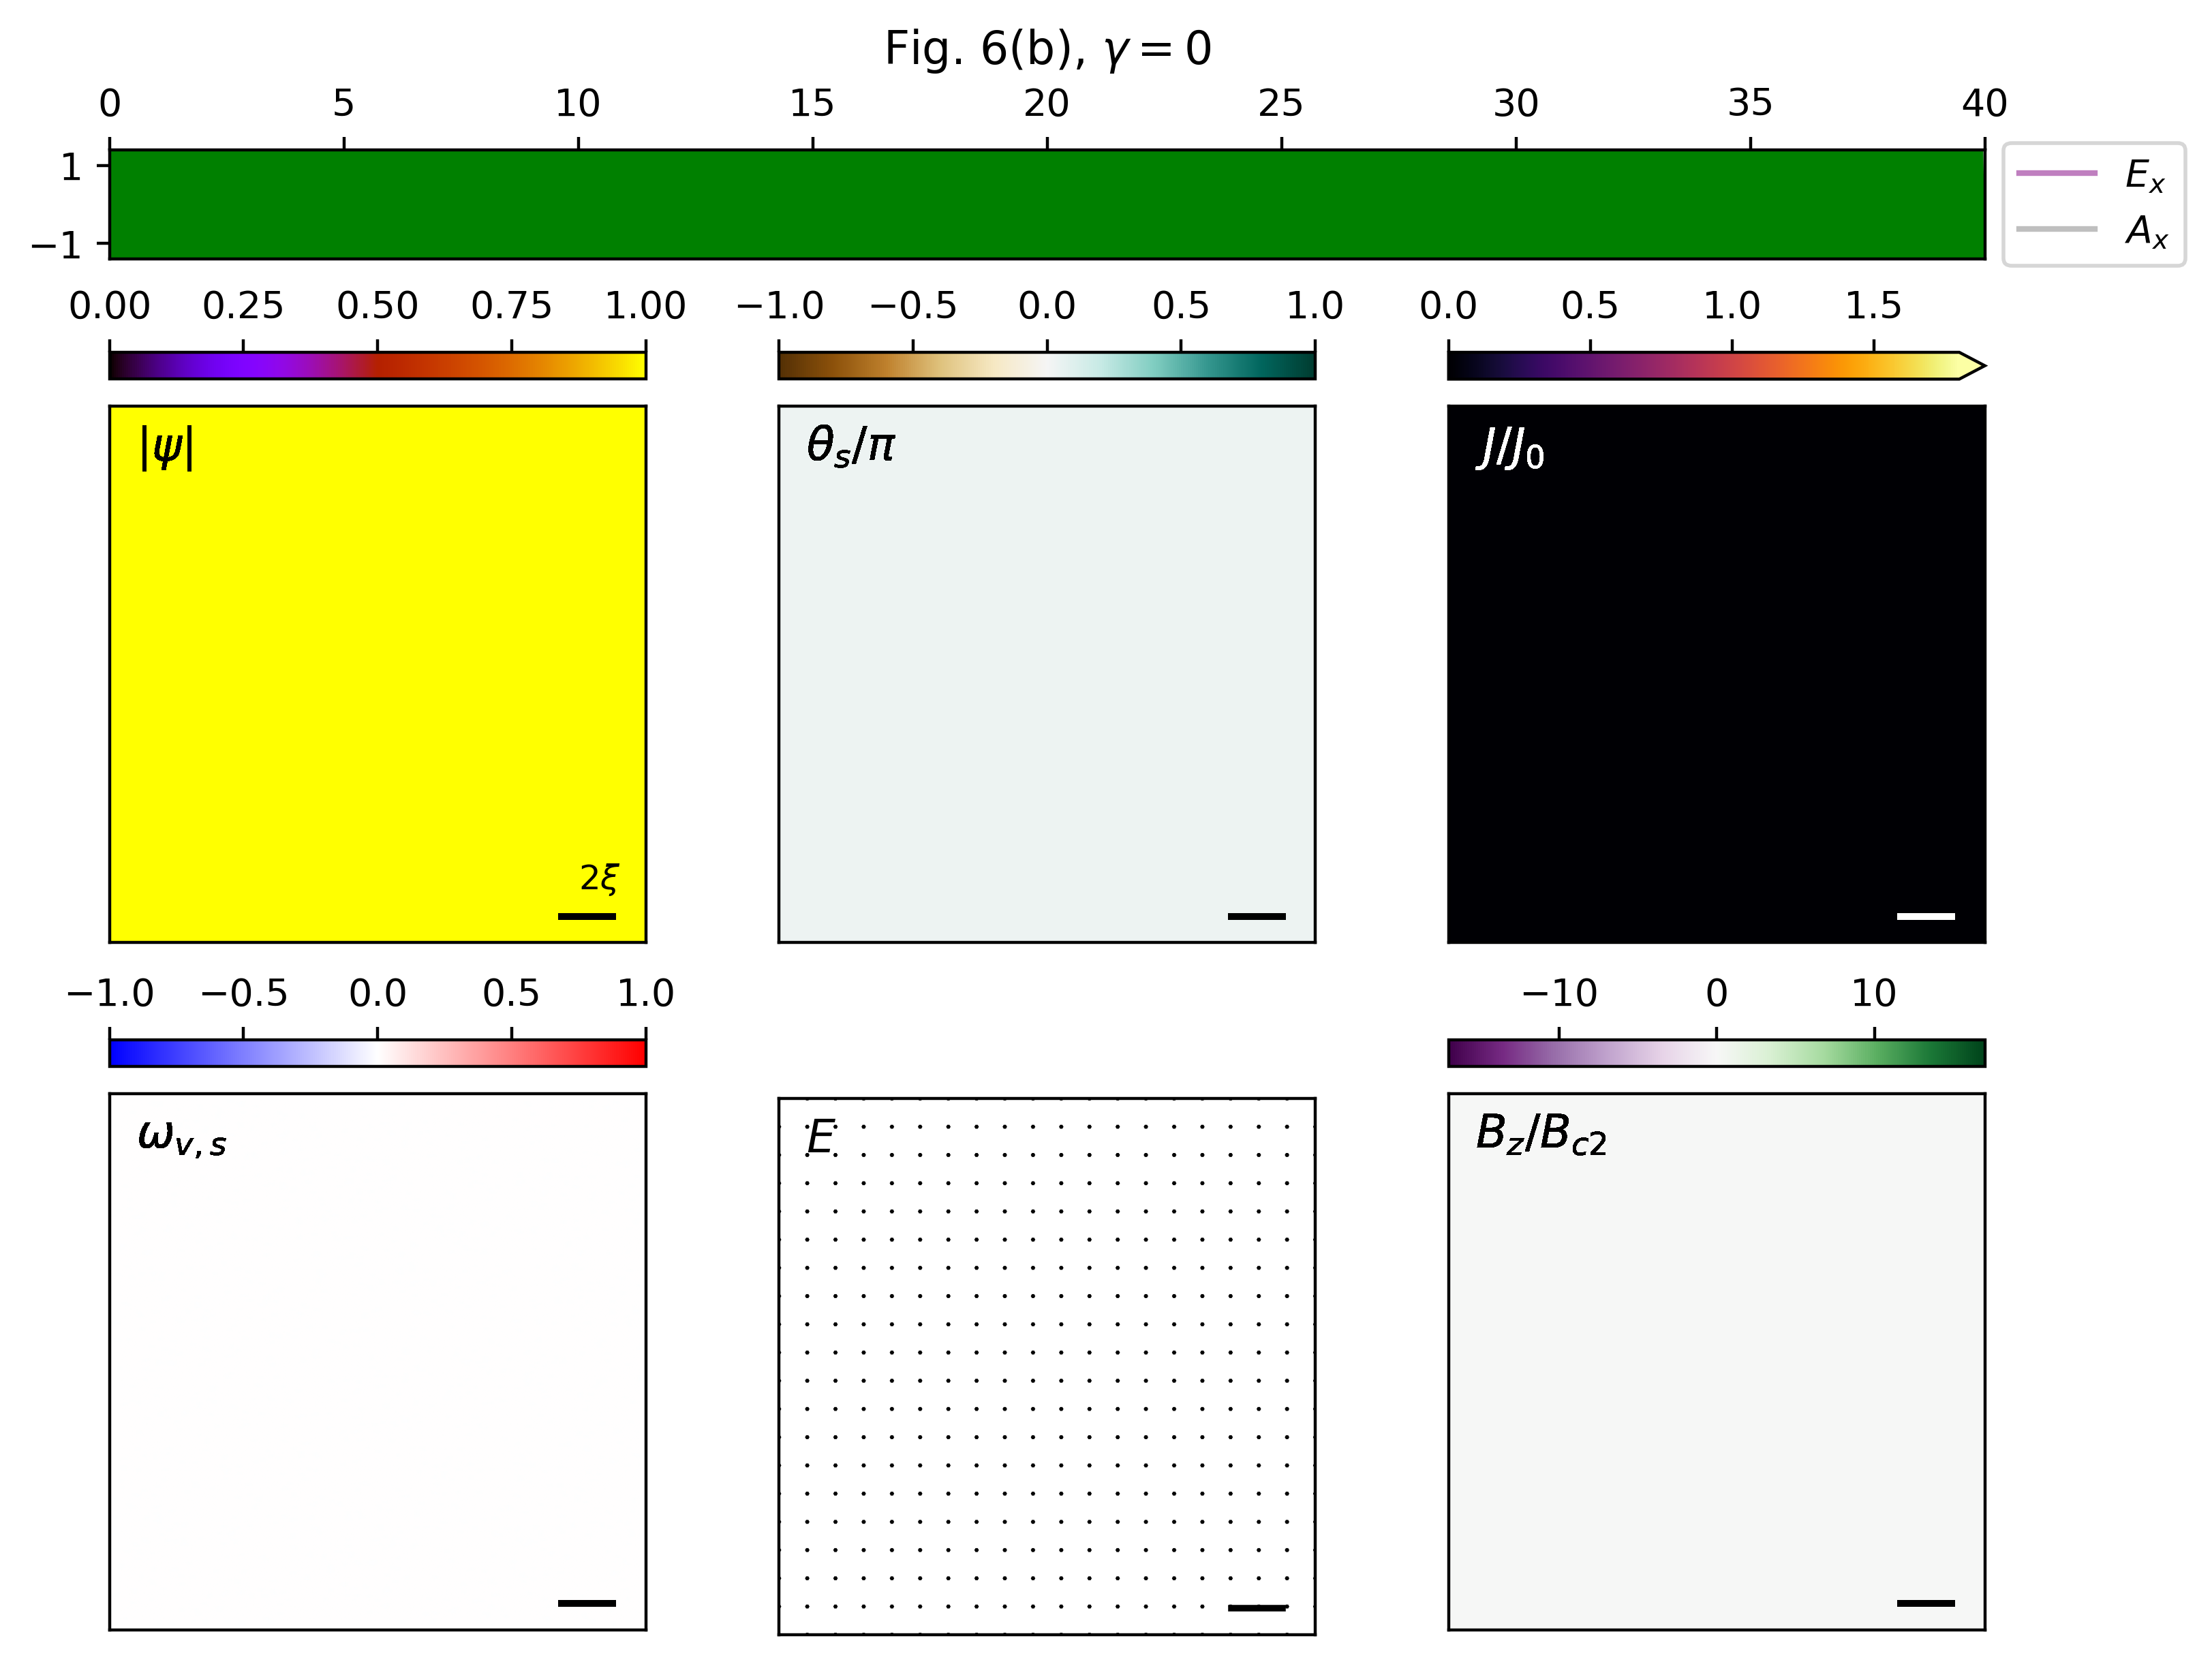

In [22]:
### Build-up subplot

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as mtrans

dpi=200
fps=20
# w_input = 2*np.pi/40
# E0i = 2
solve_time = 40
save_frame = 2
max_frame = int(len(time)/save_frame)
frame_set = np.arange(max_frame)*save_frame
frame_set = frame_set[345+123:]

iniframe = frame_set[0]
print(iniframe)

ti_set = [1,2,3]
Parameter_set = ti_set
K0 = 2.095153729869544
time=time/time.max()*solve_time
Bc2_value = Bc2.to(field_units).magnitude

# f, axes  = plt.subplots(nrows=3, ncols=len(Parameter_set), sharey=True, sharex=True, figsize=(10,5), dpi=dpi, height_ratios = [0.8, 3, 3]) # constrained_layout=True,
circle = plt.Circle((0, 0), w0/xi, color='c',fill=False,linestyle='--')

mag_cmap = "gnuplot"#"viridis"
phase_cmap = "BrBG"#"twilight_shifted"
vorticity_cmap = "bwr"
j_cmap = 'inferno'
cmap_all = [' ',mag_cmap, phase_cmap, j_cmap, vorticity_cmap, ' ', "PRGn"]
vmin_all = [  0,       0,        -1,       0,             -1,   0,    -17]
vmax_all = [  1,       1,         1,    1.8,              1,   1,     17]
# rset = np.linspace(0, 1, 100)
# vorticity_cmap = ListedColormap((new_cbar(rset))**1.5)#"bwr"

psi_label = "$|\\psi|$"
phase_label = "$\\theta_s / \\pi$"
vorticity_label = "$\\omega_{v,s}$"
j_label = "$J/J_0$"
label_all = [' ', psi_label, phase_label, j_label, vorticity_label,'$E$','$B_z/B_{c2}$']
labelfontsize = 12
labelcolor_all = [' ', 'k', 'k', 'white', 'k', 'k', 'k']

# create objects
fig = plt.figure(constrained_layout=True, figsize=(8,6), dpi=dpi)
gs = GridSpec(3, 3, figure=fig, height_ratios = [0.6, 3, 3], width_ratios = [1, 1, 1])

# create sub plots as grid
ax = {}
ax[0] = fig.add_subplot(gs[0, 0:])
ax[0].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)


ax1 = ax[0]
color = 'purple'
# ax1.set_xlabel('Time ($\\tau_{GL}$)')
# ax1.set_ylabel('$E_{x}$', color=color)
ax1.plot(time[iniframe:], Egt[iniframe:]/max(Egt), color=color, alpha=0.5, label='$E_x$')
color = 'gray'
# ax1.set_ylabel('$A_{x}$', color=color)  # we already handled the x-label with ax1
ax1.plot(time[iniframe:], Egtt[iniframe:], color=color, alpha=0.5, label='$A_x$')
# ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([-1.4,1.4])
ax1.set_xlim([0,solve_time])
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_yticks([-1,1])
ax1.set_title('Fig. 6(b), $\\gamma=0$')
left, bottom, width, height = (0, -2, time[iniframe], 4)
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="green", alpha=1)
ax1.add_patch(rect)
for Nti in range(int(solve_time*w_input/2/np.pi)+1): ax1.axvline(x=(Nti)*(2*np.pi/w_input),color='g',linestyle='dashed',linewidth=0.5)

ax[1] = fig.add_subplot(gs[1, 0])
ax[2] = fig.add_subplot(gs[1, 1])
ax[3] = fig.add_subplot(gs[1, 2])
ax[4] = fig.add_subplot(gs[-1, 0])
ax[5] = fig.add_subplot(gs[-1, 1])
ax[6] = fig.add_subplot(gs[-1, 2])

# ax[7] = fig.add_subplot(gs[0, 0])
# ax[7].set_axis_off()
# txt = ax[7].text(.5, .5, 'Timeline ($t/ \\tau_{GL}$)',
#         rotation = 0,
#         ha = 'center',
#         fontsize = 15,
#         clip_on=True)


if MAKE_ANIMATIONS:

# Basic sattings
    input_file = SC_solution
    shading = "gouraud"
    # fps = 10
    # dpi= 100
    max_cols = 6
    min_frame = 0
    max_frame = -1
    autoscale = False
    dimensionles = False
    xlim = [(Xtri/xi).min(), (Xtri/xi).max()]
    ylim = [(Ytri/xi).min(), (Ytri/xi).max()]
    axis_labels = False
    axes_off = False
    title_off = False
    full_title = True
    logger = None
    figure_kwargs = None
    writer = None
    quiver_scale = 1
    quiver_mesh_n = 20
    width_quiver = 0.08
    dimensionless = False
    # quantities = ("order_parameter", "phase")
    output_file = folder_name+'/'+'test'+"_video.mp4"

    def timescan(frame):
        yout = np.ones_like(time)*(-2)
        yout[frame] = 2
        return yout

    for num_set in tqdm(frame_set):
            collections = []
            height = 2
            width = 2
            w0 = 0.4
            X = np.linspace(-width/2,width/2,quiver_mesh_n)
            Y = np.linspace(-height/2,height/2,quiver_mesh_n)
            Xv, Yv = np.meshgrid(X, Y)
            Bzmax, Bzmin = [find_max_Bz(Xv,Yv,E0i,constant_Bz,c,w_input), -find_max_Bz(Xv,Yv,E0i,constant_Bz,c,w_input)]

            # num_set = 1 # Change here for test !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            ti = dict(input_file['data'][str(num_set)].attrs)['time']
            Nti = findval(time,ti)
            psi = np.copy((SC_solution['data'][str(num_set)]['psi'][:]))
            K0 = 2.095153729869544
            # J, Jxnorm, Jynorm = get_J_xy(SC_solution,mesh_input,"s+n",str(num_set),Jmax=J_plot.max())
            J = get_J(SC_solution,mesh_input,"s+n",str(num_set))
            vorticity = get_vorticity(SC_solution,mesh_input,"vorticity",str(num_set))
            # Jx = interpolate.griddata(np.array([Xtri,Ytri]).T, Jxnorm,(Xv, Yv), method='linear',)
            # Jy = interpolate.griddata(np.array([Xtri,Ytri]).T, Jynorm,(Xv, Yv), method='linear',)

            axn = ax[0]
            collection = axn.plot(time, timescan(num_set), color='green')
            # collections.append(collection)

            E_x, E_y = E_input_frame(Xv,Yv,ti,take_real=False)
            B_x, B_y, B_z = E2Bv(Xv,Yv,E0i*E_x,E0i*E_y,constant_Bz,c,w_input)

            for i in range(1,5):

                if i==1: Z_value = np.abs(psi)
                if i==2: Z_value = np.angle(psi) / np.pi
                if i==3: Z_value = np.copy(J)/K0
                if i==4: Z_value = np.copy(vorticity)/vor_plot.max()
                cmap = str(np.copy(cmap_all[i]))
                label = str(np.copy(label_all[i]))
                vmax = np.copy(vmax_all[i])
                vmin = np.copy(vmin_all[i])
                labeltextcolor = str(np.copy(labelcolor_all[i]))

                axn = ax[i]
                collection = axn.tripcolor(
                        Xtri/xi,
                        Ytri/xi,
                        Z_value,
                        triangles=mesh_input.elements,
                        shading=shading,
                        cmap=cmap,
                        vmin=vmin,
                        vmax=vmax,
                    )
                # if i==3: axn.streamplot(Xv/xi, Yv/xi, Jx, Jy, color="white", density=.8, linewidth=0.5)
                if num_set==iniframe:
                  if i!=3: cbar = fig.colorbar(collection, ax=axn, location='top')
                if num_set==iniframe:
                  if i==3: cbar = fig.colorbar(collection, ax=axn, location='top',extend='max')
                # cbar.set_label(opts.clabel)
                axn.set_aspect("equal")
                axn.set_xlim(xlim)
                axn.set_ylim(ylim)
                axn.set_xticks([])
                axn.set_yticks([])
                if num_set==iniframe:
                  if int(i)==1: axn.text(7.5,-8,'$2\\xi$', fontsize=9)
                fontprops = fm.FontProperties(size=4, family='monospace')
                scalebar = AnchoredSizeBar(axn.transData,
                               2, '            ', 'lower right',
                               pad=0.15,
                               color=labeltextcolor,
                               frameon=False,
                               size_vertical=.1,fontproperties=fontprops)
                axn.add_artist(scalebar)
                axn.text(-9,8,label, fontsize=labelfontsize, color=labeltextcolor)
                # collections.append(collection)

            if True: # For new plot: "E"
                i = 5
                label = str(np.copy(label_all[i]))
                axn = ax[i]
                if num_set>iniframe: collection_E = axn.clear()
                collection_E = axn.quiver(
                                    Xv/xi,
                                    Yv/xi,
                                    np.real(E_x),
                                    np.real(E_y),
                                    scale=quiver_scale,
                                    scale_units='x',
                                    width=width_quiver*abs(X[2]-X[1]),)
                axn.set_aspect("equal")
                axn.set_xlim(xlim)
                axn.set_ylim(ylim)
                axn.set_xticks([])
                axn.set_yticks([])
                fontprops = fm.FontProperties(size=4, family='monospace')
                scalebar = AnchoredSizeBar(axn.transData,
                               2, '            ', 'lower right',
                               pad=0.15,
                               color=labeltextcolor,
                               frameon=False,
                               size_vertical=.1,fontproperties=fontprops)
                axn.add_artist(scalebar)
                axn.text(-9,8,label, fontsize=labelfontsize, color=labeltextcolor)
                # if num_set==0: collections.append(collection_E)

            if True: # For new plot: "Bz"
                i = 6
                vmax = np.copy(vmax_all[i])
                vmin = np.copy(vmin_all[i])
                label = str(np.copy(label_all[i]))
                axn = ax[i]
                collection = axn.pcolormesh(
                        X/xi,
                        Y/xi,
                        np.real(B_z)/Bc2_value,
                        cmap="PRGn",
                        shading='gouraud',
                        vmin=vmin,
                        vmax=vmax,
                )
                if num_set==iniframe: cbar = plt.colorbar(collection, ax=axn, location='top')
                # cbar.set_label('$B_{z}$ ['+field_units+']')
                axn.set_aspect("equal")
                # axn.set_title('$B_{z}$ ')
                axn.set_xlim(xlim)
                axn.set_ylim(ylim)
                axn.set_xticks([])
                axn.set_yticks([])
                fontprops = fm.FontProperties(size=4, family='monospace')
                scalebar = AnchoredSizeBar(axn.transData,
                               2, '            ', 'lower right',
                               pad=0.15,
                               color=labeltextcolor,
                               frameon=False,
                               size_vertical=.1,fontproperties=fontprops)
                axn.add_artist(scalebar)

                axn.text(-9,8,label, fontsize=labelfontsize, color=labeltextcolor)
                # collections.append(collection)
            plt.savefig(folder_name+'/SI_fig6b/'+str(num_set)+'.png')


''' Done. '''

In [ ]:
np.real(B_z)
# w0=4
# def E_input_frame(Xv,Yv,ti,*,take_real: bool=True):
#     Zv = np.zeros_like(Xv)
#     Ex, Ey, Ez =  (E_LG_t(Xv, Yv, Zv, t=ti, w=w_input, w0=w0, E0=E0i, xc_Gauss=xc_Gauss, yc_Gauss=yc_Gauss,
#                              phi0_t=phi0_t, phi0_xy=phi0_xy, p=p, l=l, s=s,
#                              tau=tau_0.to(time_units).magnitude, polarization_modulation=polarization_modulation,
#                              t_on=t_on, t_off=t_off, Bz=constant_Bz, time_evolute=time_evolute,
#                              angular_freq_units=angular_freq_units, length_units=length_units, E_field_units=E_field_units, time_units=time_units,))
#     if take_real: return np.real(Ex)/E0i, np.real(Ey)/E0i
#     else:         return Ex/E0i, Ey/E0i
if True:
            height = 2
            width = 2
            w0 = 0.4
            X = np.linspace(-width/2,width/2,quiver_mesh_n)
            Y = np.linspace(-height/2,height/2,quiver_mesh_n)
            Xv, Yv = np.meshgrid(X, Y)
            Bzmax, Bzmin = [find_max_Bz(Xv,Yv,E0i,constant_Bz,c,w_input), -find_max_Bz(Xv,Yv,E0i,constant_Bz,c,w_input)]
ti=0
E_x, E_y = E_input_frame(Xv,Yv,ti,take_real=False)
B_x, B_y, B_z = E2Bv(Xv,Yv,E0i*E_x,E0i*E_y,constant_Bz,c,w_input)
print(E_x.max())
print(B_z.max())
Xv
height
width

(0.933091439014576+0j)
0j


2

In [ ]:
quiver_test = True
if quiver_test:
        title_set = 'quiver test'
        E_x, E_y, E_z = (E_LG_t(Xv, Yv, Zv, t=0, w=w_input, w0=w0, E0=E0i_set[0], xc_Gauss=xc_Gauss, yc_Gauss=yc_Gauss,
                                 phi0_t=0*np.pi/2, phi0_xy=phi0_xy, p=p, l=l, s=s,
                                 t_on=t_on, t_off=t_off, Bz=constant_Bz, time_evolute=time_evolute,
                                 tau=tau_0.to(time_units).magnitude, polarization_modulation=polarization_modulation,
                                 angular_freq_units=angular_freq_units, length_units=length_units, E_field_units=E_field_units, time_units=time_units,))
        B_x, B_y, B_z = E2Bv(Xv,Yv,E_x,E_y,constant_Bz,c,w_input)
        plot_EM(X,Y,np.real(E_x),np.real(E_y),np.real(B_z),E0i=E0i_set[0],title=title_set,figsize=(9,3),scale=quiver_scale,dpi=dpi,width_quiver=width_quiver)


ValueError: operands could not be broadcast together with shapes (20,20) (200,200) 

In [ ]:
# # Bc2.to(field_units).magnitude
# # (np.real(B_z)).min()
# # # Bzmax
# # # # # E0i
# # # # c
# # # # Bz_max
# # # find_max_Bz(Xv,Yv,2,0,c,w_input)*0.16*3.14/2
# # # # Phi0.to('mT*um^2')
# # # # Xv.min()
# # # # w_input
# len(time)
# vor_plot[3:18,1:100].max()
# vor_plot.max()

0.08708127594698091

In [ ]:
# # import ffmpeg

# max_frame = int(len(time)/save_frame)
# frame_set = np.arange(max_frame)*save_frame

# for frame in tqdm(frame_set):
#     frame += min_frame
#     num_set = frame
#     ti = dict(input_file['data'][str(num_set)].attrs)['time']
#     Nti = findval(time,ti)
#     psi = np.copy((SC_solution['data'][str(num_set)]['psi'][:]))
#     J = get_J(SC_solution,mesh_input,"s+n",str(num_set))/K0
#     vorticity = get_vorticity(SC_solution,mesh_input,"vorticity",str(num_set))
#     # J, Jxnorm, Jynorm = get_J_xy(SC_solution,mesh_input,"s+n",str(num_set),Jmax=J_plot.max())
#     # Jx = interpolate.griddata(np.array([Xtri,Ytri]).T, Jxnorm,(Xv, Yv), method='linear',)
#     # Jy = interpolate.griddata(np.array([Xtri,Ytri]).T, Jynorm,(Xv, Yv), method='linear',)

#     axn = ax[0]
#     collection = axn.plot(time, timescan(num_set), color='green')
#     # fig.canvas.draw()

#     E_x, E_y = E_input_frame(Xv,Yv,ti,take_real=False)
#     B_x, B_y, B_z = E2Bv(Xv,Yv,E0i*E_x,E0i*E_y,constant_Bz,c,w_input)

#     for i in range(1,5):

#         if i==1: Z_value = np.abs(psi)
#         if i==2: Z_value = np.angle(psi) / np.pi
#         if i==3: Z_value = np.copy(J)
#         if i==4: Z_value = np.copy(vorticity)/vor_plot.max()
#         cmap = str(np.copy(cmap_all[i]))
#         label = str(np.copy(label_all[i]))
#         vmax = np.copy(vmax_all[i])
#         vmin = np.copy(vmin_all[i])
#         labeltextcolor = str(np.copy(labelcolor_all[i]))

#         axn = ax[i]
#         collection = axn.tripcolor(
#                         Xtri/xi,
#                         Ytri/xi,
#                         Z_value,
#                         triangles=mesh_input.elements,
#                         shading=shading,
#                         cmap=cmap,
#                         vmin=vmin,
#                         vmax=vmax,
#             )
#         # if i==3: axn.streamplot(Xv/xi, Yv/xi, Jx, Jy, color="white", density=.8, linewidth=0.5)
#         if int(i)==1: axn.text(7.5,-8,'$2\\xi$', fontsize=9)
#         scalebar = AnchoredSizeBar(axn.transData,
#                                2, '            ', 'lower right',
#                                pad=0.15,
#                                color=labeltextcolor,
#                                frameon=False,
#                                size_vertical=.1,fontproperties=fontprops)
#         axn.add_artist(scalebar)
#         axn.text(-9,8,label, fontsize=labelfontsize, color=labeltextcolor)
#         # fig.canvas.draw()

#     if True: # For new plot: "E"
#         i = 5
#         label = str(np.copy(label_all[i]))
#         axn = ax[i]
#         # collection = axn.quiver(
#         #                 Xv/xi,
#         #                 Yv/xi,
#         #                 np.real(E_x),
#         #                 np.real(E_y),
#         #                 scale=quiver_scale,
#         #                 scale_units='x',
#         #                 width=width_quiver*abs(X[2]-X[1]),
#         # )
#         collection_E.set_UVC(np.real(E_x),np.real(E_y))
#         scalebar = AnchoredSizeBar(axn.transData,
#                                2, '            ', 'lower right',
#                                pad=0.15,
#                                color=labeltextcolor,
#                                frameon=False,
#                                size_vertical=.1,fontproperties=fontprops)
#         axn.add_artist(scalebar)
#         axn.text(-9,8,label, fontsize=labelfontsize, color=labeltextcolor)
#         # fig.canvas.draw()

#     if True: # For new plot: "Bz"
#         i = 6
#         vmax = np.copy(vmax_all[i])
#         vmin = np.copy(vmin_all[i])
#         label = str(np.copy(label_all[i]))
#         axn = ax[i]
#         collection = axn.pcolormesh(
#                         X/xi,
#                         Y/xi,
#                         np.real(B_z)/Bc2_value,
#                         cmap="PRGn",
#                         shading='gouraud',
#                         vmin=vmin,
#                         vmax=vmax,
#         )
#         scalebar = AnchoredSizeBar(axn.transData,
#                                2, '            ', 'lower right',
#                                pad=0.15,
#                                color=labeltextcolor,
#                                frameon=False,
#                                size_vertical=.1,fontproperties=fontprops)
#         axn.add_artist(scalebar)

#         axn.text(-9,8,label, fontsize=labelfontsize, color=labeltextcolor)
#         # fig.canvas.draw()
#         plt.savefig(folder_name+'/SI_fig7a/'+str(frame)+'.png')


# # # output_file = os.path.join(os.getcwd(), output_file)
# # # fname = os.path.basename(output_file)

# # max_frame = int(len(time)/save_frame)
# # # max_frame = 20

# # frame = np.arange(max_frame)*save_frame

# # anim = animation.FuncAnimation(
# #                 fig,
# #                 update,
# #                 frames=frame,
# #                 interval=1e3 / fps,
# #                 blit=False,
# # )

# # # anim.save(
# # #                     output_file,
# # #                     dpi=dpi,

# # #                     # progress_callback=lambda frame, total: pbar.update(1),
# # #                     # **kwargs,
# # #                 )

# # anim.save(folder_name+'/'+'SI_fig7a.gif', writer='pillow',dpi=dpi,)

# """ Done: animation save"""

  2%|▏         | 20/826 [00:47<31:57,  2.38s/it]


KeyboardInterrupt: 

<Figure size 1500x500 with 0 Axes>

In [ ]:
# import ffmpeg

def update(frame):
    frame += min_frame
    num_set = frame
    ti = dict(input_file['data'][str(num_set)].attrs)['time']
    Nti = findval(time,ti)
    psi = np.copy((SC_solution['data'][str(num_set)]['psi'][:]))
    J = get_J(SC_solution,mesh_input,"s+n",str(num_set))/K0
    vorticity = get_vorticity(SC_solution,mesh_input,"vorticity",str(num_set))
    # J, Jxnorm, Jynorm = get_J_xy(SC_solution,mesh_input,"s+n",str(num_set),Jmax=J_plot.max())
    # Jx = interpolate.griddata(np.array([Xtri,Ytri]).T, Jxnorm,(Xv, Yv), method='linear',)
    # Jy = interpolate.griddata(np.array([Xtri,Ytri]).T, Jynorm,(Xv, Yv), method='linear',)

    axn = ax[0]
    collection = axn.plot(time, timescan(num_set), color='green')
    fig.canvas.draw()

    E_x, E_y = E_input_frame(Xv,Yv,ti,take_real=False)
    B_x, B_y, B_z = E2Bv(Xv,Yv,E0i*E_x,E0i*E_y,constant_Bz,c,w_input)

    for i in range(1,5):

        if i==1: Z_value = np.abs(psi)
        if i==2: Z_value = np.angle(psi) / np.pi
        if i==3: Z_value = np.copy(J)
        if i==4: Z_value = np.copy(vorticity)/vor_plot.max()
        cmap = str(np.copy(cmap_all[i]))
        label = str(np.copy(label_all[i]))
        vmax = np.copy(vmax_all[i])
        vmin = np.copy(vmin_all[i])
        labeltextcolor = str(np.copy(labelcolor_all[i]))

        axn = ax[i]
        collection = axn.tripcolor(
                        Xtri/xi,
                        Ytri/xi,
                        Z_value,
                        triangles=mesh_input.elements,
                        shading=shading,
                        cmap=cmap,
                        vmin=vmin,
                        vmax=vmax,
            )
        # if i==3: axn.streamplot(Xv/xi, Yv/xi, Jx, Jy, color="white", density=.8, linewidth=0.5)
        if int(i)==1: axn.text(7.5,-8,'$2\\xi$', fontsize=9)
        scalebar = AnchoredSizeBar(axn.transData,
                               2, '            ', 'lower right',
                               pad=0.15,
                               color=labeltextcolor,
                               frameon=False,
                               size_vertical=.1,fontproperties=fontprops)
        axn.add_artist(scalebar)
        axn.text(-9,8,label, fontsize=labelfontsize, color=labeltextcolor)
        fig.canvas.draw()

    if True: # For new plot: "E"
        i = 5
        label = str(np.copy(label_all[i]))
        axn = ax[i]
        # collection = axn.quiver(
        #                 Xv/xi,
        #                 Yv/xi,
        #                 np.real(E_x),
        #                 np.real(E_y),
        #                 scale=quiver_scale,
        #                 scale_units='x',
        #                 width=width_quiver*abs(X[2]-X[1]),
        # )
        collection_E.set_UVC(np.real(E_x),np.real(E_y))
        scalebar = AnchoredSizeBar(axn.transData,
                               2, '            ', 'lower right',
                               pad=0.15,
                               color=labeltextcolor,
                               frameon=False,
                               size_vertical=.1,fontproperties=fontprops)
        axn.add_artist(scalebar)
        axn.text(-9,8,label, fontsize=labelfontsize, color=labeltextcolor)
        fig.canvas.draw()

    if True: # For new plot: "Bz"
        i = 6
        vmax = np.copy(vmax_all[i])
        vmin = np.copy(vmin_all[i])
        label = str(np.copy(label_all[i]))
        axn = ax[i]
        collection = axn.pcolormesh(
                        X/xi,
                        Y/xi,
                        np.real(B_z)/Bc2_value,
                        cmap="PRGn",
                        shading='gouraud',
                        vmin=vmin,
                        vmax=vmax,
        )
        scalebar = AnchoredSizeBar(axn.transData,
                               2, '            ', 'lower right',
                               pad=0.15,
                               color=labeltextcolor,
                               frameon=False,
                               size_vertical=.1,fontproperties=fontprops)
        axn.add_artist(scalebar)

        axn.text(-9,8,label, fontsize=labelfontsize, color=labeltextcolor)
        fig.canvas.draw()

# output_file = os.path.join(os.getcwd(), output_file)
# fname = os.path.basename(output_file)

max_frame = int(len(time)/save_frame)
# max_frame = 20

frame = np.arange(max_frame)*save_frame

anim = animation.FuncAnimation(
                fig,
                update,
                frames=frame,
                interval=1e3 / fps,
                blit=False,
)

# anim.save(
#                     output_file,
#                     dpi=dpi,

#                     # progress_callback=lambda frame, total: pbar.update(1),
#                     # **kwargs,
#                 )

anim.save(folder_name+'/'+'SI_fig7a.gif', writer='pillow',dpi=dpi,)

""" Done: animation save"""

KeyboardInterrupt: 

In [ ]:
len(time)

8267

In [ ]:
# import ffmpeg
!pip install ffmpeg-python

   ---------------------------------------- 0.0/491.3 kB ? eta -:--:--
    --------------------------------------- 10.2/491.3 kB ? eta -:--:--
    --------------------------------------- 10.2/491.3 kB ? eta -:--:--
   -- ------------------------------------ 30.7/491.3 kB 262.6 kB/s eta 0:00:02
   ---- ---------------------------------- 61.4/491.3 kB 363.1 kB/s eta 0:00:02
   ------- ------------------------------- 92.2/491.3 kB 435.7 kB/s eta 0:00:01
   ----------------------- ---------------- 286.7/491.3 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------  481.3/491.3 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------  481.3/491.3 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 491.3/491.3 kB 1.5 MB/s eta 0:00:00


['.config', 'drive', 'sample_data']

9

### Note

nothing.

In [ ]:
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
# import matplotlib.font_manager as fm
# # ti_set = [66,72,80,88,96]
# # ti_label = ['0', '$1/2\\cdot\\pi$', '$\\pi$', '$3/2\\cdot\\pi$', '$2\\cdot\\pi$']
# dpi=100

# Parameter_set = ti_set

# f, axes  = plt.subplots(nrows=3, ncols=len(Parameter_set), sharey=True, sharex=True, figsize=(5,2.5), dpi=dpi) # constrained_layout=True,
# circle = plt.Circle((0, 0), w0/xi, color='c',fill=False,linestyle='--')

# for num_set in range(len(Parameter_set)):
#     ti = ti_set[num_set]
#     Nti = findval(time,ti)
#     psi = np.copy((SC_solution['data'][str(Nti)]['psi'][:]))
#     mag = np.abs(psi)
#     phase = np.angle(psi) / np.pi
#     vorticity = get_vorticity(SC_solution,mesh_input,"vorticity",str(Nti))
#     points = device.points
#     triangles = device.triangles
#     im = axes[0,int(num_set)].tripcolor(
#         Xtri/xi,
#         Ytri/xi,
#         mag,
#         triangles=voronoi_tri,
#         vmin=0,
#         vmax=1,
#         cmap=mag_cmap,
#         shading=shading,
#     )
#     if int(num_set)==0: axes[0,int(num_set)].add_patch(circle)
#     if int(num_set)==len(Parameter_set)-1: cbar = f.colorbar(im, ax=axes[0,int(num_set)])
#     if int(num_set)==len(Parameter_set)-1: cbar.set_label(psi_label)
#     # if int(num_set)==0: axes[0,int(num_set)].set_ylabel('$y$ [$\\xi$]')#(f"$y$ [${length_units:~L}$]")
#     axes[0,int(num_set)].set_xlim(np.array([min(Xtri/xi),max(Xtri/xi)])*0.4)
#     axes[0,int(num_set)].set_ylim(np.array([min(Ytri/xi),max(Ytri/xi)])*0.4)
#     axes[0,int(num_set)].set_aspect("equal")
#     axes[0,int(num_set)].set_xticks([])
#     axes[0,int(num_set)].set_yticks([])
#     fontprops = fm.FontProperties(size=4, family='monospace')
#     scalebar = AnchoredSizeBar(axes[0,int(num_set)].transData,
#                                1,  '      ', 'lower right',
#                                pad=0.15,
#                                color='k',
#                                frameon=False,
#                                size_vertical=.1,fontproperties=fontprops)
#     axes[0,int(num_set)].add_artist(scalebar)
#     if int(num_set)==0: axes[0,int(num_set)].text(2.5,-2,'$\\xi$', fontsize=9)
#     # axes[0,int(num_set)].text(-3,2.5,'$\\tau_{'+str(num_set+1)+'}$', fontsize=12)
#     # axes[0,int(num_set)].axis('off')

#     im = axes[1,int(num_set)].tripcolor(
#         Xtri/xi,
#         Ytri/xi,
#         phase,
#         triangles=voronoi_tri,
#         vmin=-1,
#         vmax=1,
#         cmap=phase_cmap,
#         shading=shading,
#     )
#     if int(num_set)==len(Parameter_set)-1: cbar = f.colorbar(im, ax=axes[1,int(num_set)])
#     if int(num_set)==len(Parameter_set)-1: cbar.set_label(phase_label)
#     # if int(num_set)==0: axes[1,int(num_set)-1].set_ylabel('$y$ [$\\xi$]')#(f"$y$ [${length_units:~L}$]")
#     axes[1,int(num_set)].set_xlim(np.array([min(Xtri/xi),max(Xtri/xi)])*0.4)
#     axes[1,int(num_set)].set_ylim(np.array([min(Ytri/xi),max(Ytri/xi)])*0.4)
#     # axes[1,int(num_set)].set_xlabel('$x$ [$\\xi$]')#(f"$x$ [${length_units:~L}$]")
#     axes[1,int(num_set)].set_aspect("equal")
#     axes[1,int(num_set)].set_xticks([])
#     axes[1,int(num_set)].set_yticks([])

#     # px = findval(X,0)
#     # phase_interp = interpolate.griddata(np.array([Xtri,Ytri]).T,
#     #             np.angle(SC_solution['data'][str(Nti)]['psi']),(Xv, Yv), method='cubic',)
#     # axes[1,int(num_set)].plot(X/xi,np.unwrap(phase_interp[px,:])/2/np.pi)
#     # px = findval(X,0.4)
#     # phase_interp = interpolate.griddata(np.array([Xtri,Ytri]).T,
#     #             np.angle(SC_solution['data'][str(Nti)]['psi']),(Xv, Yv), method='cubic',)
#     # axes[1,int(num_set)].plot(X/xi,np.unwrap(phase_interp[px,:])/2/np.pi)

#     fontprops = fm.FontProperties(size=4, family='monospace')
#     scalebar = AnchoredSizeBar(axes[1,int(num_set)].transData,
#                                1, '      ', 'lower right',
#                                pad=0.15,
#                                color='k',
#                                frameon=False,
#                                size_vertical=.1,fontproperties=fontprops)
#     axes[1,int(num_set)].add_artist(scalebar)
#     # axes[1,int(num_set)].axis('off')

#     im = axes[2,int(num_set)].tripcolor(
#         Xtri/xi,
#         Ytri/xi,
#         vorticity/vor_plot[60:140,findval(ti_show,ti_set[2])].max(),
#         triangles=voronoi_tri,
#         vmin=-1,
#         vmax=1,
#         cmap=vorticity_cmap,
#         shading=shading,
#     )
#     if int(num_set)==len(Parameter_set)-1: cbar = f.colorbar(im, ax=axes[2,int(num_set)])
#     if int(num_set)==len(Parameter_set)-1: cbar.set_label(vorticity_label)
#     # if int(num_set)==0: axes[2,int(num_set)-1].set_ylabel('$y$ [$\\xi$]')#(f"$y$ [${length_units:~L}$]")
#     axes[2,int(num_set)].set_xlim(np.array([min(Xtri/xi),max(Xtri/xi)])*0.4)
#     axes[2,int(num_set)].set_ylim(np.array([min(Ytri/xi),max(Ytri/xi)])*0.4)
#     # axes[1,int(num_set)].set_xlabel('$x$ [$\\xi$]')#(f"$x$ [${length_units:~L}$]")
#     axes[2,int(num_set)].set_aspect("equal")
#     axes[2,int(num_set)].set_xticks([])
#     axes[2,int(num_set)].set_yticks([])

#     fontprops = fm.FontProperties(size=4, family='monospace')
#     scalebar = AnchoredSizeBar(axes[2,int(num_set)].transData,
#                                1, '      ', 'lower right',
#                                pad=0.15,
#                                color='k',
#                                frameon=False,
#                                size_vertical=.1,fontproperties=fontprops)
#     axes[2,int(num_set)].add_artist(scalebar)
#     # axes[1,int(num_set)].axis('off')


#     plt.subplots_adjust(left=0,bottom=0,right=1,top=1,hspace=0.15,wspace=0)

# plt.savefig(folder_name+'/'+'test_save.png',bbox_inches='tight')